In [1]:
# =================== CELDA 0 — CONFIG GLOBAL & HELPERS ===================
import os, sys, random, warnings, pathlib, logging
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)

################################################################################
# 1. Reproducibilidad total
################################################################################
def seed_everything(seed: int = 42):
    """
    Fija todas las semillas pseudoaleatorias que razonablemente controlamos:
    - Python `random`
    - Hash aleatorio de Python
    - NumPy
    - (opcional) PyTorch si está disponible

    NO garantiza determinismo bitwise en CUDA, pero quita la aleatoriedad obvia.
    """
    import importlib

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

    if importlib.util.find_spec("torch") is not None:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.use_deterministic_algorithms(False)
        if torch.backends.cudnn.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

SEED = 42
seed_everything(SEED)

################################################################################
# 2. Estilo "Nature-ready" para todas las figuras
################################################################################
def set_nature_style():
    """
    Ajusta parámetros globales de Matplotlib/Seaborn para figuras tipo Nature:
    - texto editable en Illustrator (fonttype=42)
    - tamaños de fuente consistentes
    - ejes sin spines top/right
    - ticks hacia afuera
    """
    sns.set_theme(style="white", context="paper")
    mpl.rcParams.update({
        # texto editable en Illustrator / Affinity
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "svg.fonttype": "none",

        # tipografía
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],

        # tamaños (en pt aprox)
        "font.size": 9,
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,

        # estética de ejes
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "xtick.direction": "out",
        "ytick.direction": "out",

        # salida
        "figure.dpi": 300,
        "savefig.pad_inches": 0.02,
    })

set_nature_style()

################################################################################
# 3. Rutas y parámetros globales de la corrida
#    (AJUSTA ESTO para el nuevo proyecto si cambian paths o sufijos)
################################################################################
if 'N_FOLDS' not in globals():      N_FOLDS = 5
if 'CLF' not in globals():          CLF = 'mlp'
if 'SUFFIX' not in globals():       SUFFIX = '_integrated_gradients_top50'

# Canales de conectividad activos en este proyecto
if 'CHANNELS_TO_USE' not in globals():
    CHANNELS_TO_USE = [1, 2, 5]   # <-- cámbialo si tu nuevo modelo usa otros canales

# Directorio base de la corrida FULL (nuevo proyecto)
if 'BASE_RUN_DIR' not in globals():
    BASE_RUN_DIR = Path('/home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual')  # <-- AJUSTA SI CAMBIA

# Rutas del tensor global y metadata
if 'GLOBAL_TENSOR_PATH' not in globals():
    GLOBAL_TENSOR_PATH = (
        '/home/diego/Escritorio/limpio/'
        'AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_'
        'AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/'
        'GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_'
        'AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz'
    )

if 'METADATA_PATH' not in globals():
    METADATA_PATH = '/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv'

FIG_DIR = Path('./Figures_Nature')
TBL_DIR = Path('./Tables_Nature')
FIG_DIR.mkdir(exist_ok=True, parents=True)
TBL_DIR.mkdir(exist_ok=True, parents=True)

RUN_CFG = {
    "SEED": SEED,
    "N_FOLDS": N_FOLDS,
    "CLF": CLF,
    "SUFFIX": SUFFIX,
    "CHANNELS_TO_USE": CHANNELS_TO_USE,
    "BASE_RUN_DIR": str(BASE_RUN_DIR),
    "GLOBAL_TENSOR_PATH": GLOBAL_TENSOR_PATH,
    "METADATA_PATH": METADATA_PATH,
    "FIG_DIR": str(FIG_DIR),
    "TBL_DIR": str(TBL_DIR),
}

################################################################################
# 4. Helper para guardar figuras en alta resolución listas para el paper
################################################################################
def savefig_nature(fig: mpl.figure.Figure,
                   path_no_ext,
                   dpi_png: int = 600,
                   transparent_png: bool = False,
                   extra_meta: dict | None = None):
    """
    Guarda dos versiones de la figura:
      - PDF (vectorial, texto editable)
      - PNG (alta resolución)
    """
    p = pathlib.Path(path_no_ext)
    p.parent.mkdir(parents=True, exist_ok=True)

    meta_pdf = {
        "Creator": "Matplotlib",
        "Title": p.name,
        "CreationDate": datetime.now(),
    }
    if extra_meta:
        meta_pdf.update(extra_meta)

    fig.savefig(p.with_suffix(".pdf"),
                metadata=meta_pdf,
                bbox_inches="tight")

    fig.savefig(p.with_suffix(".png"),
                dpi=dpi_png,
                transparent=transparent_png,
                metadata={"Creator": "Matplotlib"},
                bbox_inches="tight")

################################################################################
# 5. Log de estado y silencio de logs ruidosos
################################################################################
print(">> CONFIG INICIAL (signature notebook)")
for k, v in RUN_CFG.items():
    print(f"   {k}: {v}")
print("✔️  Setup gráfico y helpers cargados.\n")

logging.getLogger('fontTools').setLevel(logging.WARNING)
logging.getLogger('fontTools.subset').setLevel(logging.WARNING)
os.environ.setdefault("TQDM_DISABLE", "1")


>> CONFIG INICIAL (signature notebook)
   SEED: 42
   N_FOLDS: 5
   CLF: mlp
   SUFFIX: _integrated_gradients_top50
   CHANNELS_TO_USE: [1, 2, 5]
   BASE_RUN_DIR: /home/diego/proyectos/betavae-xai-ad/results/vae_clf_ad_ld256_beta66_manual
   GLOBAL_TENSOR_PATH: /home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz
   METADATA_PATH: /home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado2.csv
   FIG_DIR: Figures_Nature
   TBL_DIR: Tables_Nature
✔️  Setup gráfico y helpers cargados.



'1'

In [2]:
# =================== CELDA 1 — CARGA TENSOR & METADATA (CN/AD + FOLDS) ===================
import numpy as np
import pandas as pd

# --- Carga maestro del NPZ y metadata ---
_npz = np.load(GLOBAL_TENSOR_PATH)
global_tensor_data = _npz["global_tensor_data"]              # [n_subj, n_channels, R, R]
subject_ids_all   = _npz["subject_ids"].astype(str)

meta = pd.read_csv(METADATA_PATH)
meta["SubjectID"] = meta["SubjectID"].astype(str).str.strip()

# Alineamos el NPZ con metadata
idx_df = pd.DataFrame({
    "SubjectID": subject_ids_all,
    "tensor_idx": np.arange(len(subject_ids_all))
})

merged = idx_df.merge(meta, on="SubjectID", how="left")

# Subconjunto AD/CN
cnad_df = (
    merged
    .query("ResearchGroup_Mapped in ['CN','AD']")
    .reset_index(drop=True)
    .copy()
)

print(f"✅ cnad_df listo: {cnad_df.shape[0]} sujetos AD/CN")

# Normalización mínima de covariables
if 'Sex' in cnad_df.columns:
    cnad_df['Sex'] = (
        cnad_df['Sex']
        .replace({0:'M', 1:'F', 'm':'M', 'f':'F'})
        .astype(str)
        .str.upper()
    )

if 'Age' in cnad_df.columns:
    cnad_df['Age'] = pd.to_numeric(cnad_df['Age'], errors='coerce')

# --- Índices train/test por fold (para tests en TEST y Cohen's d) ---
fold_indices = {}
all_indices = np.arange(len(cnad_df))

for f in range(1, N_FOLDS + 1):
    test_idx_path = BASE_RUN_DIR / f"fold_{f}" / "test_indices.npy"
    if not test_idx_path.exists():
        print(f"⚠️ Falta test_indices.npy para fold {f}: {test_idx_path}")
        continue

    test_idx = np.load(test_idx_path)               # índice sobre cnad_df
    train_idx = np.setdiff1d(all_indices, test_idx, assume_unique=True)

    fold_indices[f] = {"train": train_idx, "test": test_idx}

print(f"✅ fold_indices construido para {len(fold_indices)} folds.")

# --- Info de canales (por si la necesitamos en figuras / tablas) ---
CHANNEL_CATALOG = {
    0: "Pearson_OMST_GCE_Signed_Weighted",
    1: "Pearson_Full_FisherZ_Signed",
    2: "MI_kNN_Symmetric",
    3: "dFC_AbsDiffMean",
    4: "dFC_StdDev",
    5: "DistanceCorr",
    6: "Granger_F_lag1",
}

sel_names = [CHANNEL_CATALOG[c] for c in CHANNELS_TO_USE]
print("[Canales activos]", CHANNELS_TO_USE, "=>", sel_names)


✅ cnad_df listo: 184 sujetos AD/CN
✅ fold_indices construido para 5 folds.
[Canales activos] [1, 2, 5] => ['Pearson_Full_FisherZ_Signed', 'MI_kNN_Symmetric', 'DistanceCorr']


In [3]:
# =================== CELDA 2 — CARGA RANKINGS & df_full ===================
from pathlib import Path

all_folds = []
missing_folds = []

for i in range(1, N_FOLDS + 1):
    path = BASE_RUN_DIR / f"fold_{i}" / f"interpretability_{CLF}" / f"ranking_conexiones_ANOTADO{SUFFIX}.csv"
    if not path.exists():
        print(f"⚠️ Falta ranking en fold {i}: {path}")
        missing_folds.append(i)
        continue

    df_i = pd.read_csv(path)

    # ID canónico de conexión (tupla ordenada por nombre AAL3)
    df_i["connection_id"] = [
        tuple(sorted(x)) for x in zip(df_i["src_AAL3_Name"], df_i["dst_AAL3_Name"])
    ]
    df_i["fold"] = i
    all_folds.append(df_i)

if not all_folds:
    raise FileNotFoundError("❌ No se encontró ningún ranking_conexiones_ANOTADO*.csv")

df_full = pd.concat(all_folds, ignore_index=True)

# Chequeos rápidos
assert "connection_id" in df_full.columns
assert df_full["connection_id"].map(type).eq(tuple).all(), "connection_id debe ser siempre una tupla (src,dst)."

n_folds_detected = df_full["fold"].nunique()
N = int(_npz["rois_count"]) if "rois_count" in _npz else 131
E_undirected = N * (N - 1) // 2
E_directed   = N * (N - 1)

print(f"✅ df_full cargado con {len(df_full)} filas y {n_folds_detected} folds.")
print(f"   ROIs: {N}  |  aristas posibles (undirected, sin diag): {E_undirected}")
if missing_folds:
    print(f"   ⚠️ Folds sin ranking: {missing_folds}")

# Columnas clave esperadas para el resto del notebook
expected_cols = {
    "src_AAL3_Name", "dst_AAL3_Name",
    "idx_i", "idx_j",
    "Saliency_Signed", "Rank"
}
missing_cols = expected_cols.difference(df_full.columns)
if missing_cols:
    print("⚠️ Columnas faltantes en df_full (revisa versión de CSV):", missing_cols)
else:
    print("✔️ Columnas clave presentes en df_full.")


✅ df_full cargado con 42575 filas y 5 folds.
   ROIs: 131  |  aristas posibles (undirected, sin diag): 8515
✔️ Columnas clave presentes en df_full.


In [4]:
# =================== CELDA 3 — CONSENSUS (π, τ, w_signed) & HELPERS GLOBALES ===================
from collections import Counter

# --- Parámetros del consenso (usa los del paper) ---
TOP_K_STABILITY = 250     # tamaño del top-K por fold para π, τ
CONS_PI  = 0.6
CONS_TAU = 0.6

print(f"Parámetros de consenso: TOP_K={TOP_K_STABILITY}, π≥{CONS_PI}, τ≥{CONS_TAU}")

# ----------------------------------------------------------------------
# 3.1  Frecuencia π y consistencia de signo τ / signedness
# ----------------------------------------------------------------------
# Conjunto de aristas que entran al top-K por fold
top_sets = (
    df_full
    .loc[df_full["Rank"] <= TOP_K_STABILITY]
    .groupby("fold", observed=True)["connection_id"]
    .apply(set)
)

n_folds = len(top_sets)
pi = pd.Series(Counter(e for s in top_sets for e in s)).div(n_folds)
pi.name = "pi"

# Matriz de signos de saliencia (connection_id × fold) → {−1,0,+1}
sign_mat = (
    df_full
    .set_index(["connection_id", "fold"])["Saliency_Signed"]
    .pipe(np.sign)
    .unstack()    # columnas = folds
)

# signedness: media de signos (con signo), τ: consistencia (módulo)
signedness = sign_mat.mean(axis=1).fillna(0.0).rename("signedness")  # ∈[-1,1]
tau        = sign_mat.mean(axis=1).abs().rename("tau")

df_stability = (
    pd.concat([pi, tau, signedness], axis=1)
      .fillna({"pi": 0.0, "tau": 0.0, "signedness": 0.0})
)

# ⚠️ IMPORTANTE: aplanar el MultiIndex → Index de tuplas (connection_id)
df_stability.index = pd.Index(df_stability.index, name="connection_id")

# Nombres canónicos:
#  - stability_mag = π·τ   (magnitud de estabilidad, sin signo)  → para ordenar
#  - w_signed      = π·signedness (peso con signo)               → para Fig B / glass / nodos
df_stability["stability_mag"] = df_stability["pi"] * df_stability["tau"]
df_stability["w_signed"]      = df_stability["pi"] * df_stability["signedness"]
print("✅ df_stability calculado con π, τ, signedness, stability_mag, w_signed.")
display(df_stability.head())

# ----------------------------------------------------------------------
# 3.2  Set de consenso canónico (para todas las figuras del main)
# ----------------------------------------------------------------------
consensus_set = (
    df_stability
    .query("pi >= @CONS_PI and tau >= @CONS_TAU")
    .sort_values("stability_mag", ascending=False)
)

print(f"🔎 Consensus Set: {len(consensus_set)} aristas con π≥{CONS_PI} y τ≥{CONS_TAU}")

if len(consensus_set):
    n_pos = int((consensus_set["w_signed"] >  0).sum())
    n_neg = int((consensus_set["w_signed"] <  0).sum())
    print(f"   • pro-AD (w_signed>0): {n_pos}")
    print(f"   • pro-CN (w_signed<0): {n_neg}")
    display(consensus_set.head(10))

# ----------------------------------------------------------------------
# 3.3  Mapeo ROI → Red funcional (Refined / Yeo17)
# ----------------------------------------------------------------------
net_src_col = "src_Refined_Network" if "src_Refined_Network" in df_full.columns else "src_Yeo17_Network"
net_dst_col = "dst_Refined_Network" if "dst_Refined_Network" in df_full.columns else "dst_Yeo17_Network"

roi2net = {}

for _, r in df_full[[ "src_AAL3_Name", net_src_col ]].dropna().drop_duplicates().iterrows():
    roi2net[r["src_AAL3_Name"]] = r[net_src_col]

for _, r in df_full[[ "dst_AAL3_Name", net_dst_col ]].dropna().drop_duplicates().iterrows():
    roi2net.setdefault(r["dst_AAL3_Name"], r[net_dst_col])

print(f"✅ roi2net construido para {len(roi2net)} ROIs.")

# ----------------------------------------------------------------------
# 3.4  Lateralidad hemisférica (base para Panel C: Right-Hemisphere Dominance)
# ----------------------------------------------------------------------
midline_tokens = {'VER','VPL','PAG','NCR','tVPL','VER7','VER8','VER9'}

def hemi_of(roi: str) -> str:
    """Devuelve 'L', 'R', 'M'(midline) o 'U'(unknown) para un nombre AAL3."""
    if not isinstance(roi, str):
        return 'U'
    if roi.endswith('R'):
        return 'R'
    if roi.endswith('L'):
        return 'L'
    base = ''.join([c for c in roi if not c.isdigit()])
    return 'M' if any(t in base for t in midline_tokens) else 'U'

df_full['hemi_src'] = df_full['src_AAL3_Name'].map(hemi_of)
df_full['hemi_dst'] = df_full['dst_AAL3_Name'].map(hemi_of)

# Quitamos conexiones con ROIs de línea media / desconocidos
df_lat_clean = df_full.query("hemi_src in ['L','R'] and hemi_dst in ['L','R']").copy()
print(f"✅ df_lat_clean: {len(df_lat_clean)} conexiones L/R para análisis de lateralidad.")

def p_rr_by_fold(df: pd.DataFrame, K: int) -> pd.DataFrame:
    """
    Proporción de conexiones intra-hemisféricas R–R en el Top-K (por fold).
    Incluye también los conteos RR y LL, para tablas y p-values.
    """
    df_intra = df[df['hemi_src'] == df['hemi_dst']]
    top = df_intra[df_intra["Rank"] <= K]
    out = []
    for f, g in top.groupby("fold", observed=True):
        rr = (g["hemi_src"] == "R").sum()
        ll = (g["hemi_src"] == "L").sum()
        n  = rr + ll
        out.append({
            "fold": int(f),
            "TopK": K,
            "RR": rr,
            "LL": ll,
            "N": n,
            "p_RR": (rr / n) if n > 0 else np.nan
        })
    return pd.DataFrame(out)

df_lat_plot = pd.concat(
    [p_rr_by_fold(df_lat_clean, K) for K in (50, 100, 200)],
    ignore_index=True
)

print("✅ df_lat_plot listo para la figura de lateralidad (Panel C).")
display(df_lat_plot.head())

# ----------------------------------------------------------------------
# 3.5  Mapa conexión → (i,j) de ROI (para Cohen's d en Panel D)
# ----------------------------------------------------------------------
if not {"idx_i", "idx_j"}.issubset(df_full.columns):
    print("⚠️ Advertencia: df_full no tiene columnas idx_i / idx_j (se necesitarán para Panel D).")
    conn_map = None
else:
    conn_map = (
        df_full[["connection_id", "idx_i", "idx_j"]]
        .drop_duplicates("connection_id")
        .set_index("connection_id")
        .astype(int)
    )
    print(f"✅ conn_map construido para {len(conn_map)} conexiones (idx_i, idx_j).")


Parámetros de consenso: TOP_K=250, π≥0.6, τ≥0.6
✅ df_stability calculado con π, τ, signedness, stability_mag, w_signed.


pi  tau  signedness  stability_mag  \
connection_id                                                               
(Occipital_Inf_R, Postcentral_L)      0.2  0.2         0.2           0.04   
(Cerebelum_Crus1_R, Vent_Str_L)       0.2  1.0        -1.0           0.20   
(Cerebelum_Crus1_R, Frontal_Sup_2_R)  0.4  0.6         0.6           0.24   
(Cerebelum_6_L, OFClat_R)             0.2  0.6         0.6           0.12   
(Cingulate_Post_L, Parietal_Inf_R)    0.4  0.2        -0.2           0.08   

                                      w_signed  
connection_id                                   
(Occipital_Inf_R, Postcentral_L)          0.04  
(Cerebelum_Crus1_R, Vent_Str_L)          -0.20  
(Cerebelum_Crus1_R, Frontal_Sup_2_R)      0.24  
(Cerebelum_6_L, OFClat_R)                 0.12  
(Cingulate_Post_L, Parietal_Inf_R)       -0.08

🔎 Consensus Set: 10 aristas con π≥0.6 y τ≥0.6
   • pro-AD (w_signed>0): 4
   • pro-CN (w_signed<0): 6


pi  tau  signedness  stability_mag  \
connection_id                                                              
(Cerebelum_7b_L, OFClat_L)           0.6  1.0        -1.0           0.60   
(OFCant_L, OFCmed_L)                 0.6  1.0         1.0           0.60   
(Cingulate_Post_L, Thal_MDm_L)       0.6  0.6        -0.6           0.36   
(Insula_R, OFCant_R)                 0.6  0.6         0.6           0.36   
(ACC_pre_L, OFCant_L)                0.6  0.6         0.6           0.36   
(Cingulate_Post_L, SupraMarginal_L)  0.6  0.6        -0.6           0.36   
(Cerebelum_4_5_L, OFClat_L)          0.6  0.6        -0.6           0.36   
(Cerebelum_10_L, Postcentral_R)      0.6  0.6        -0.6           0.36   
(OFCant_L, SupraMarginal_R)          0.6  0.6         0.6           0.36   
(Temporal_Pole_Sup_R, Thal_MDm_L)    0.6  0.6        -0.6           0.36   

                                     w_signed  
connection_id                                  
(Cerebelum_7b_L, OFClat_L)              -0.60  
(OFCant_L, OFCmed_L)                     0.60  
(Cingulate_Post_L, Thal_MDm_L)          -0.36  
(Insula_R, OFCant_R)                     0.36  
(ACC_pre_L, OFCant_L)                    0.36  
(Cingulate_Post_L, SupraMarginal_L)     -0.36  
(Cerebelum_4_5_L, OFClat_L)             -0.36  
(Cerebelum_10_L, Postcentral_R)         -0.36  
(OFCant_L, SupraMarginal_R)              0.36  
(Temporal_Pole_Sup_R, Thal_MDm_L)       -0.36

✅ roi2net construido para 131 ROIs.
✅ df_lat_clean: 38130 conexiones L/R para análisis de lateralidad.
✅ df_lat_plot listo para la figura de lateralidad (Panel C).


fold  TopK  RR  LL   N      p_RR
0     1    50  16   4  20  0.800000
1     2    50  12  12  24  0.500000
2     3    50   2  18  20  0.100000
3     4    50  14  11  25  0.560000
4     5    50  15  11  26  0.576923

✅ conn_map construido para 8515 conexiones (idx_i, idx_j).


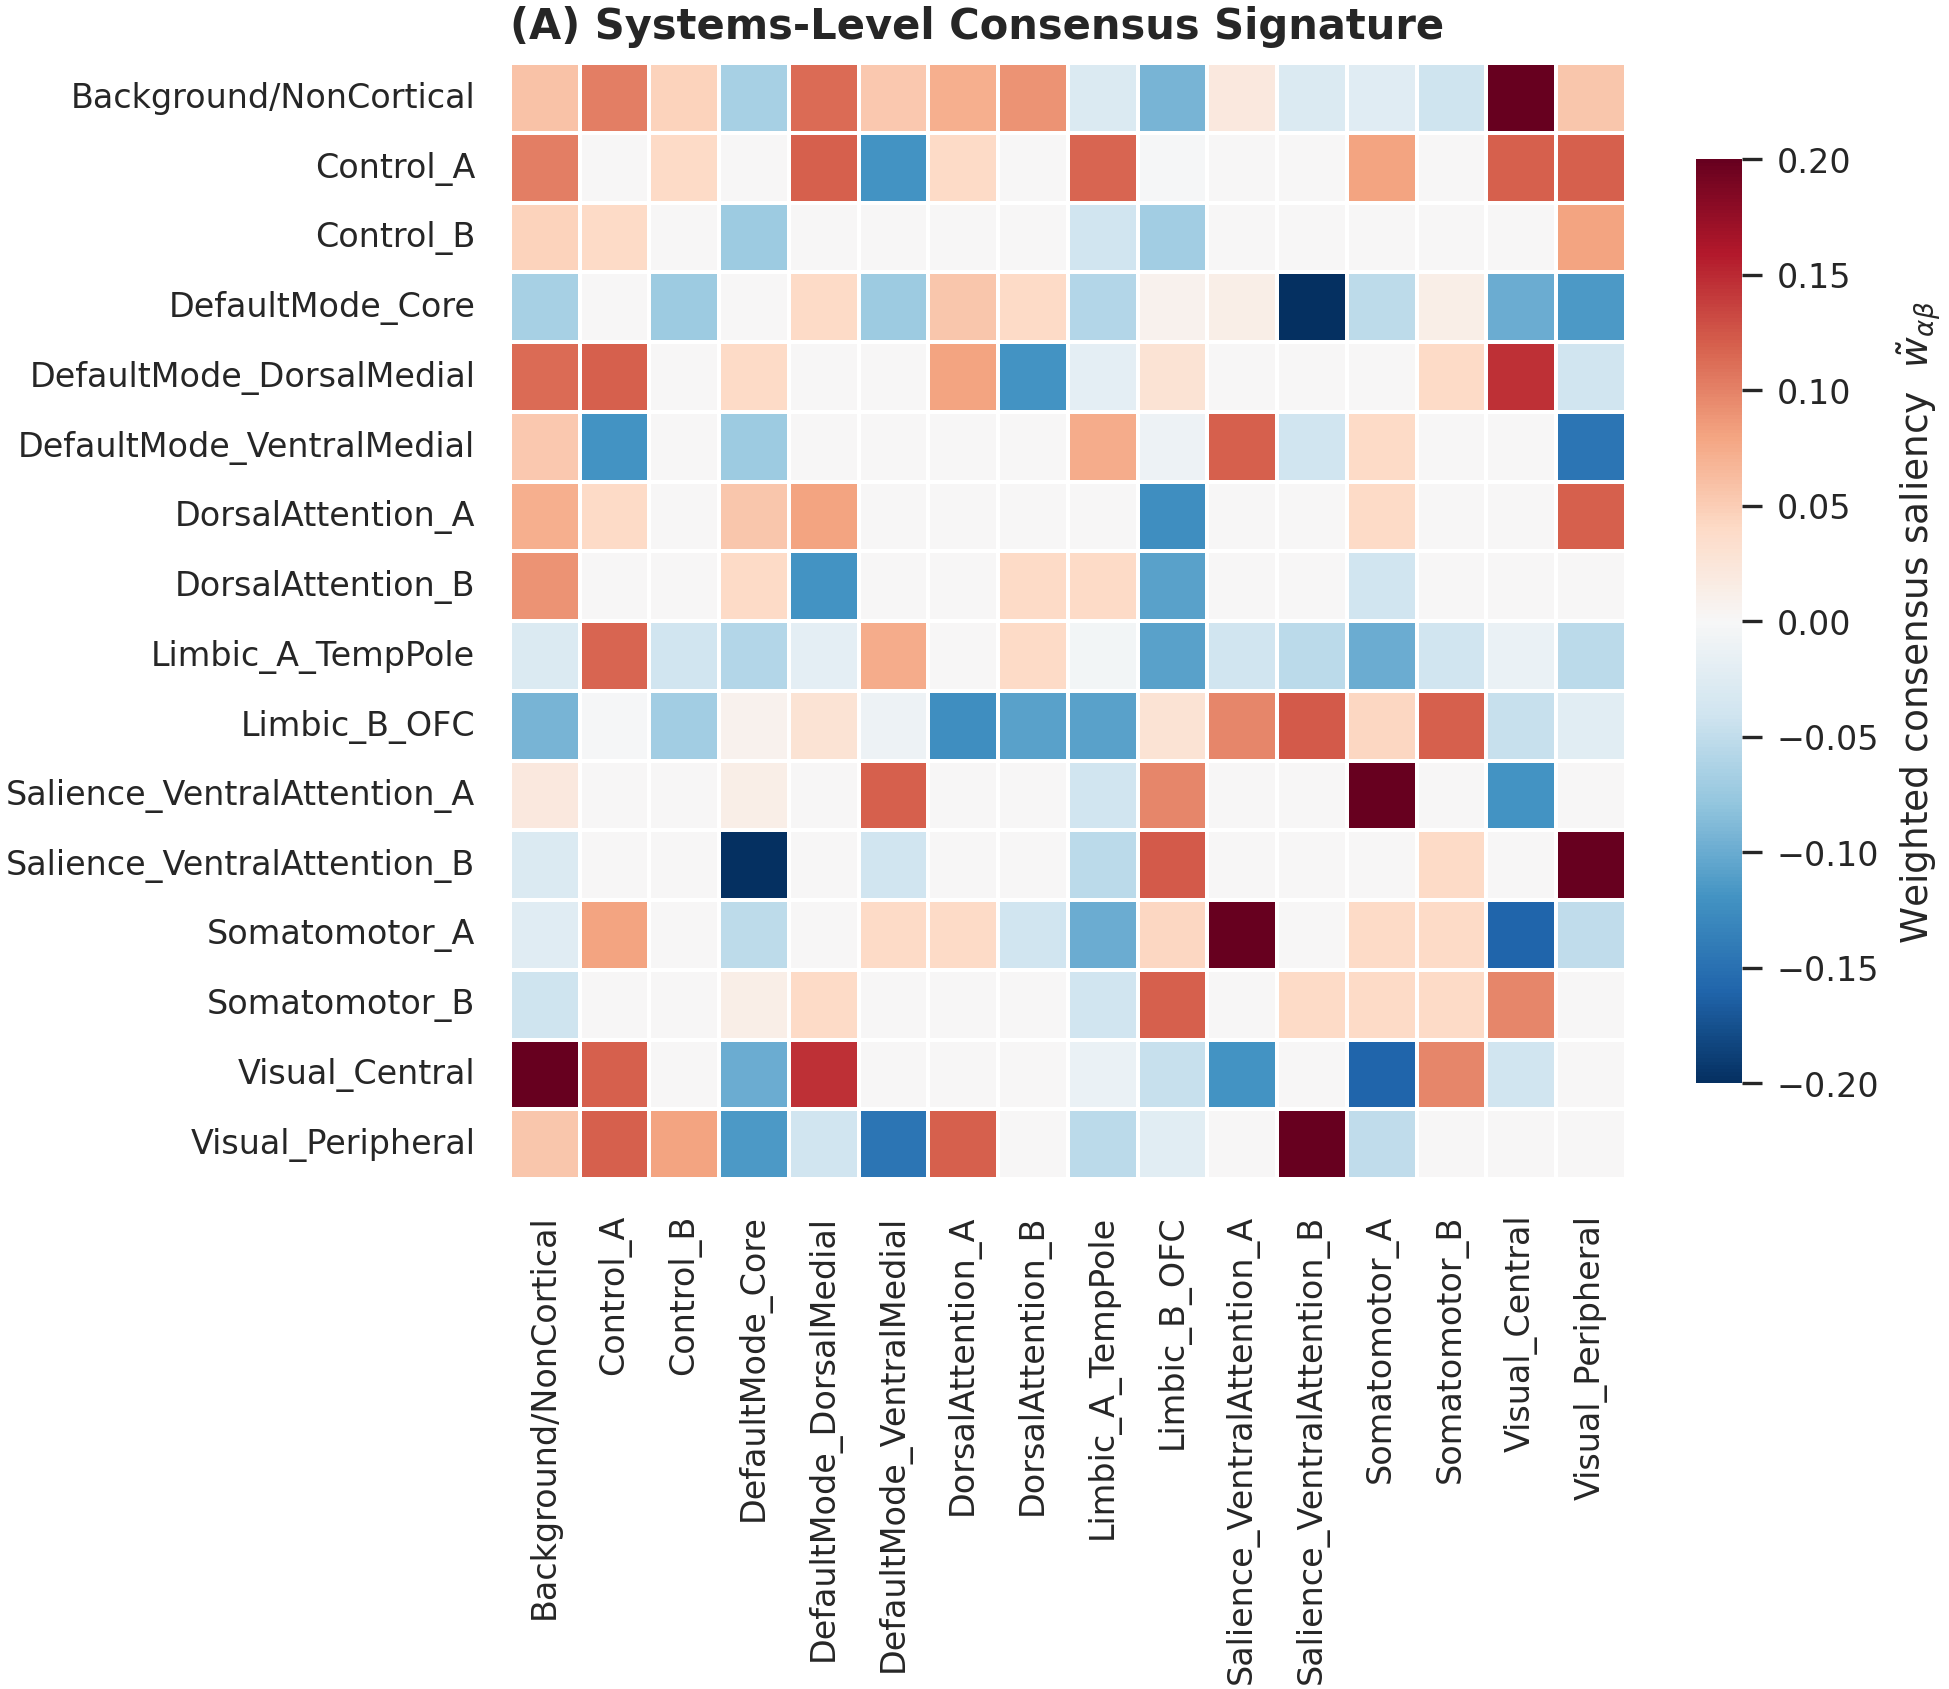

✅ Fig (A) guardada en: Figures_Nature/fig4A_systems_signature.pdf
Orden de redes: ['Background/NonCortical', 'Control_A', 'Control_B', 'DefaultMode_Core', 'DefaultMode_DorsalMedial', 'DefaultMode_VentralMedial', 'DorsalAttention_A', 'DorsalAttention_B', 'Limbic_A_TempPole', 'Limbic_B_OFC', 'Salience_VentralAttention_A', 'Salience_VentralAttention_B', 'Somatomotor_A', 'Somatomotor_B', 'Visual_Central', 'Visual_Peripheral']


In [5]:
# =================== CELDA FIG (A) — Systems-Level Consensus Signature ===================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

assert 'df_full' in globals() and 'df_stability' in globals() and 'roi2net' in globals()

# 1) Un mapeo único connection_id → (ROI_src, ROI_dst) → (net_src, net_dst)
meta_conn = (
    df_full[["connection_id", "src_AAL3_Name", "dst_AAL3_Name"]]
    .drop_duplicates("connection_id")
    .set_index("connection_id")
)

meta_conn["src_net"] = meta_conn["src_AAL3_Name"].map(roi2net)
meta_conn["dst_net"] = meta_conn["dst_AAL3_Name"].map(roi2net)

# 2) Unimos con df_stability (π, τ, signedness, stability_mag, w_signed)
stab_net = (
    df_stability
    .join(meta_conn[["src_net", "dst_net"]], how="inner")
    .dropna(subset=["src_net", "dst_net"])
    .copy()
)

# 3) Par de redes simétrico (α,β) con α≤β
stab_net["net_pair"] = [
    tuple(sorted(x)) for x in zip(stab_net["src_net"], stab_net["dst_net"])
]

# 4) Ponderar w_signed por stability_mag dentro de cada par de redes
def _weighted_score(g):
    num = (g["w_signed"] * g["stability_mag"]).sum()
    den = g["stability_mag"].sum()
    return num / den if den > 0 else 0.0

net_scores = stab_net.groupby("net_pair", observed=True).apply(_weighted_score)
net_scores.name = "score"

# 5) Matriz simétrica red×red
nets = sorted({n for pair in net_scores.index for n in pair})
mat_A = pd.DataFrame(0.0, index=nets, columns=nets)

for (na, nb), val in net_scores.items():
    mat_A.loc[na, nb] = val
    mat_A.loc[nb, na] = val

# 6) Escala centrada en cero
vmax = np.percentile(np.abs(mat_A.values), 98)
if not np.isfinite(vmax) or vmax <= 1e-6:
    vmax = 1.0
vmin = -vmax

fig_A, ax_A = plt.subplots(figsize=(6, 5))

sns.heatmap(
    mat_A,
    cmap="RdBu_r",
    vmin=vmin, vmax=vmax, center=0.0,
    square=True,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={
        "label": r"Weighted consensus saliency  $\tilde{w}_{\alpha\beta}$",
        "shrink": 0.8
    },
    ax=ax_A,
)

ax_A.set_title("(A) Systems-Level Consensus Signature", loc="left", weight="bold")
ax_A.set_xlabel("")
ax_A.set_ylabel("")
ax_A.tick_params(axis="x", rotation=90)
ax_A.tick_params(axis="y", rotation=0)

savefig_nature(fig_A, FIG_DIR / "fig4A_systems_signature")
plt.show()

print("✅ Fig (A) guardada en:", FIG_DIR / "fig4A_systems_signature.pdf")
print("Orden de redes:", list(mat_A.index))


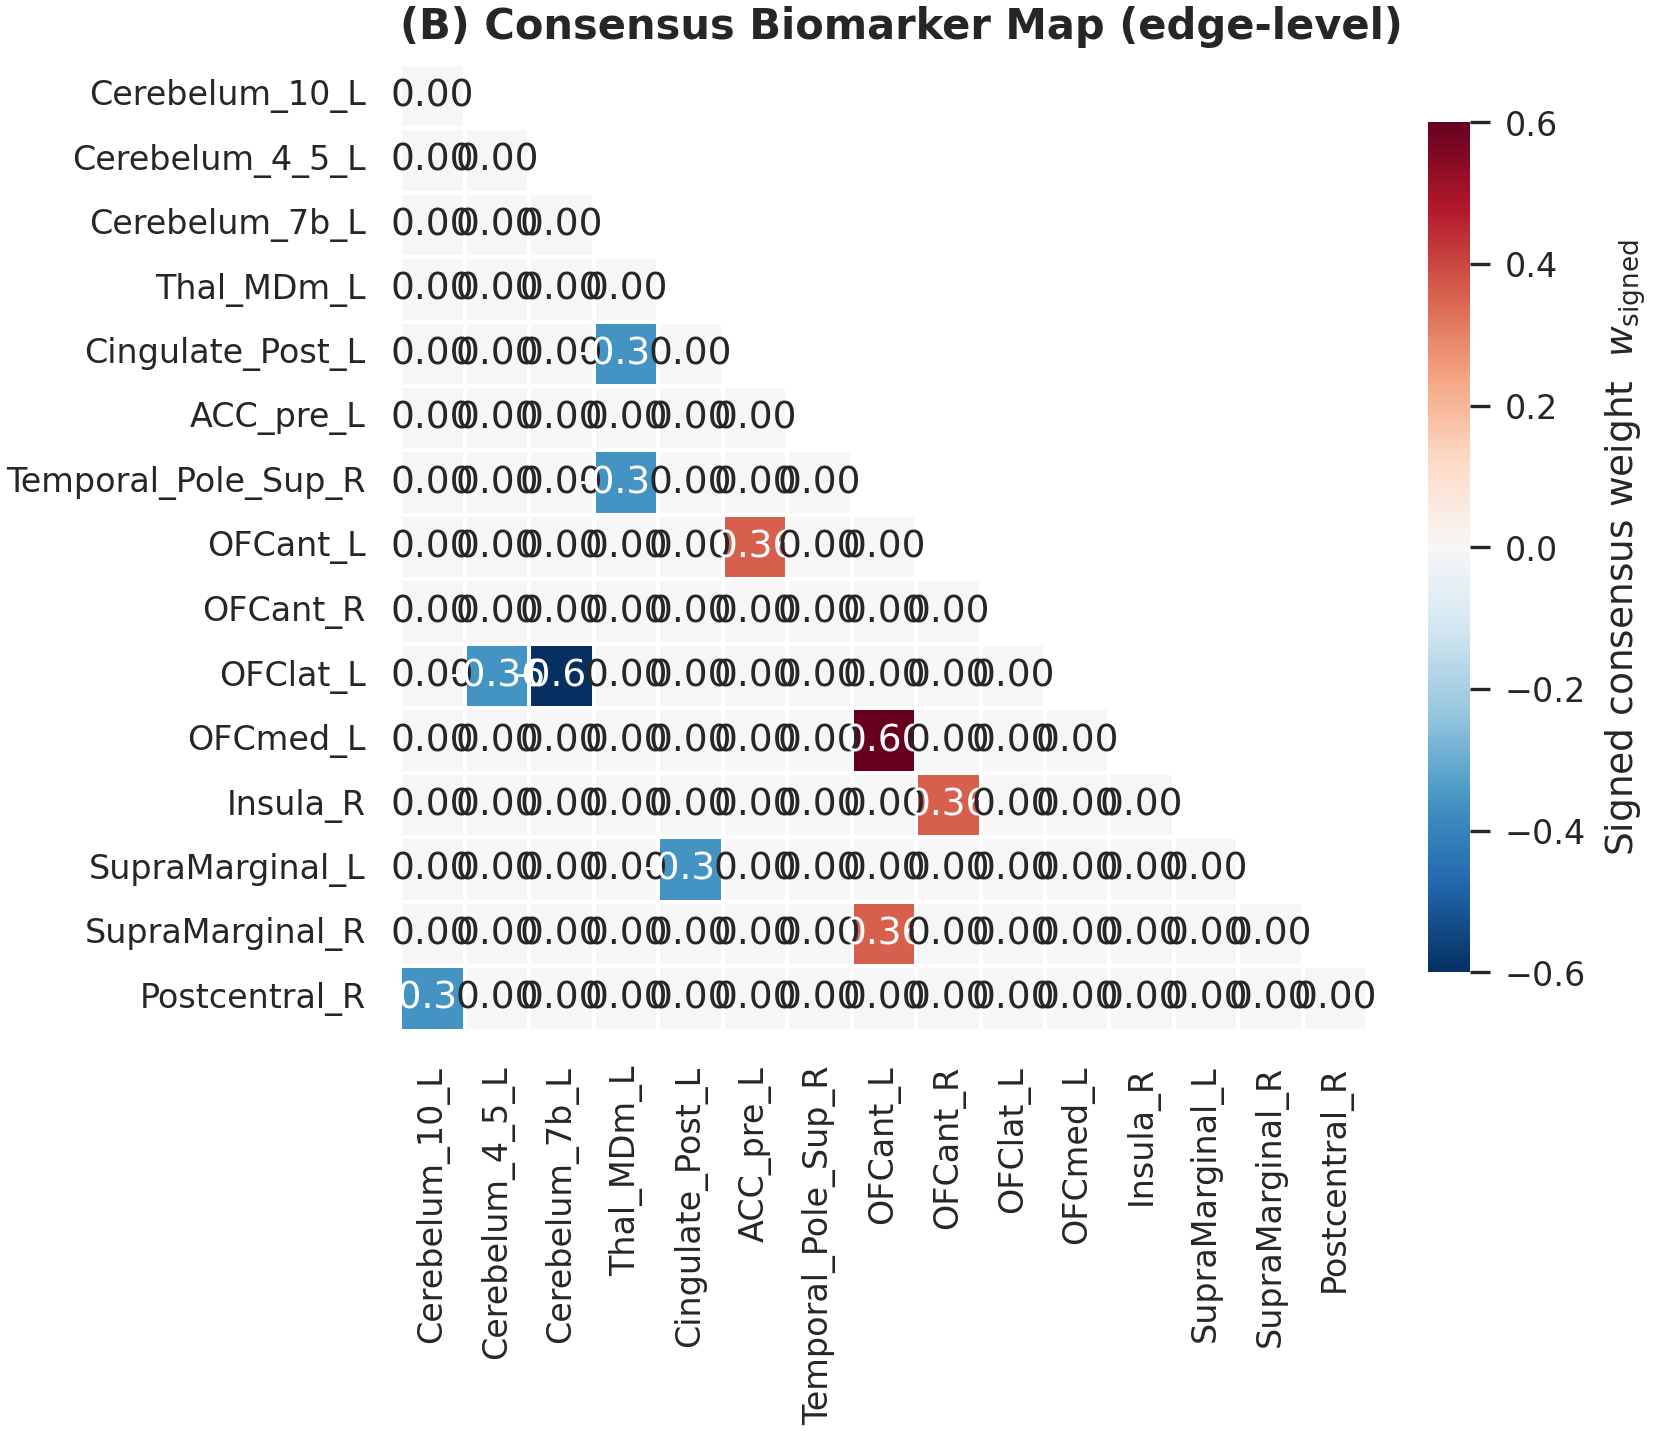

✅ Fig (B) guardada en: Figures_Nature/fig4B_consensus_edges.pdf
ROIs en consenso (ordenadas): ['Cerebelum_10_L', 'Cerebelum_4_5_L', 'Cerebelum_7b_L', 'Thal_MDm_L', 'Cingulate_Post_L', 'ACC_pre_L', 'Temporal_Pole_Sup_R', 'OFCant_L', 'OFCant_R', 'OFClat_L', 'OFCmed_L', 'Insula_R', 'SupraMarginal_L', 'SupraMarginal_R', 'Postcentral_R']


In [6]:
# =================== CELDA FIG (B) — Consensus Biomarker Map (ROI × ROI, w_signed) ===================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

assert 'consensus_set' in globals() and 'roi2net' in globals()

# 1) Pesos firmados de consenso por arista
w_edges = consensus_set["w_signed"].copy()

if w_edges.empty:
    raise RuntimeError("consensus_set está vacío; ajusta CONS_PI/CONS_TAU o TOP_K_STABILITY.")

# 2) Lista de ROIs que aparecen en el consenso y ordenadas por red funcional
rois = sorted({roi for conn in w_edges.index for roi in conn})
roi_df = pd.DataFrame({
    "ROI": rois,
    "Network": [roi2net.get(r, "Unknown") for r in rois],
})

roi_df = roi_df.sort_values(["Network", "ROI"])
ordered_rois = roi_df["ROI"].tolist()

# 3) Matriz ROI×ROI con w_signed (simétrica)
mat_B = pd.DataFrame(0.0, index=ordered_rois, columns=ordered_rois)

for (ra, rb), w in w_edges.items():
    if ra in mat_B.index and rb in mat_B.columns:
        mat_B.loc[ra, rb] = w
        mat_B.loc[rb, ra] = w

# 4) Máscara triángulo superior (para ver solo triángulo inferior)
mask = np.triu(np.ones_like(mat_B, dtype=bool), k=1)

vmax = np.max(np.abs(mat_B.values))
if not np.isfinite(vmax) or vmax <= 1e-6:
    vmax = 1.0
vmin = -vmax

fig_B, ax_B = plt.subplots(figsize=(5.2, 4.6))

sns.heatmap(
    mat_B,
    mask=mask,
    cmap="RdBu_r",
    vmin=vmin, vmax=vmax, center=0.0,
    square=True,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": r"Signed consensus weight  $w_{\mathrm{signed}}$", "shrink": 0.8},
    ax=ax_B,
    annot=(mat_B.size <= 400),  # anotar solo si la matriz es chica
    fmt=".2f",
)

ax_B.set_title("(B) Consensus Biomarker Map (edge-level)", loc="left", weight="bold")
ax_B.set_xlabel("")
ax_B.set_ylabel("")
ax_B.tick_params(axis="x", rotation=90)
ax_B.tick_params(axis="y", rotation=0)

savefig_nature(fig_B, FIG_DIR / "fig4B_consensus_edges")
plt.show()

print("✅ Fig (B) guardada en:", FIG_DIR / "fig4B_consensus_edges.pdf")
print("ROIs en consenso (ordenadas):", ordered_rois)


In [7]:
# =================== CELDA — Cohen's d por conexión (df_cohen_all) ===================
from pathlib import Path
import numpy as np
import pandas as pd

assert 'GLOBAL_TENSOR_PATH' in globals()
assert 'CHANNELS_TO_USE' in globals()
assert 'BASE_RUN_DIR' in globals()
assert 'cnad_df' in globals()
assert 'df_full' in globals()
assert 'N_FOLDS' in globals()

# --- Utilidad: Cohen's d (AD - CN) ---
def cohen_d(ad, cn, eps=1e-9):
    ad = np.asarray(ad)
    cn = np.asarray(cn)
    nx, ny = ad.size, cn.size
    if nx < 2 or ny < 2:
        return np.nan
    dof = nx + ny - 2
    s_ad = np.var(ad, ddof=1)
    s_cn = np.var(cn, ddof=1)
    pooled = np.sqrt(((nx - 1)*s_ad + (ny - 1)*s_cn) / max(dof, 1))
    if pooled < eps:
        return 0.0
    return (ad.mean() - cn.mean()) / pooled

# --- Tensor completo (sólo canales seleccionados) ---
_npz = np.load(GLOBAL_TENSOR_PATH)
tensor_all = _npz["global_tensor_data"][:, CHANNELS_TO_USE, :, :]   # [n_subj, C_sel, R, R]

# --- Mapa conexión → (i,j) ---
if not {"idx_i", "idx_j"}.issubset(df_full.columns):
    raise KeyError("df_full debe contener columnas 'idx_i' e 'idx_j'.")

conn_map = (
    df_full[["connection_id", "idx_i", "idx_j"]]
    .drop_duplicates("connection_id")
    .set_index("connection_id")
    .astype(int)
)

# --- Cálculo de d en TEST por fold y promedio ---
N_FOLDS_FOUND = df_full["fold"].nunique()
cohen_per_fold = []

for f in range(1, N_FOLDS_FOUND + 1):
    test_idx_path = BASE_RUN_DIR / f"fold_{f}" / "test_indices.npy"
    if not test_idx_path.exists():
        print(f"⚠️ Falta test_indices.npy en fold {f}: {test_idx_path}. Se omite este fold.")
        continue

    test_indices_in_cnad = np.load(test_idx_path)  # índices sobre cnad_df
    test_df = cnad_df.iloc[test_indices_in_cnad]

    ad_glob_idx = test_df.loc[test_df["ResearchGroup_Mapped"] == "AD", "tensor_idx"].to_numpy()
    cn_glob_idx = test_df.loc[test_df["ResearchGroup_Mapped"] == "CN", "tensor_idx"].to_numpy()

    if len(ad_glob_idx) < 2 or len(cn_glob_idx) < 2:
        print(f"⚠️ Muy pocos sujetos AD/CN en test para fold {f}. Se omite.")
        continue

    rows = []
    for conn, (i, j) in conn_map.iterrows():
        # valor de conectividad por sujeto (promedio sobre canales seleccionados)
        vals_all = tensor_all[:, :, i, j].mean(axis=1)  # [n_subj]
        dval = cohen_d(vals_all[ad_glob_idx], vals_all[cn_glob_idx])
        rows.append((conn, dval))

    df_fold_d = (
        pd.DataFrame(rows, columns=["connection_id", f"cohen_d_fold_{f}"])
        .set_index("connection_id")
    )
    cohen_per_fold.append(df_fold_d)

if not cohen_per_fold:
    raise RuntimeError("No se pudo calcular Cohen's d en ningún fold.")

df_cohen_all = pd.concat(cohen_per_fold, axis=1)

# Promedio (ignorando NaNs si falta algún fold)
df_cohen_all["mean_cohen_d"] = df_cohen_all.mean(axis=1, skipna=True)
df_cohen_all["std_cohen_d"]  = df_cohen_all.std(axis=1,  skipna=True)

print("✅ df_cohen_all listo con columnas:", df_cohen_all.columns.tolist())
print("   Nº de conexiones con d válido:", df_cohen_all["mean_cohen_d"].notna().sum())


✅ df_cohen_all listo con columnas: ['cohen_d_fold_1', 'cohen_d_fold_2', 'cohen_d_fold_3', 'cohen_d_fold_4', 'cohen_d_fold_5', 'mean_cohen_d', 'std_cohen_d']
   Nº de conexiones con d válido: 8515


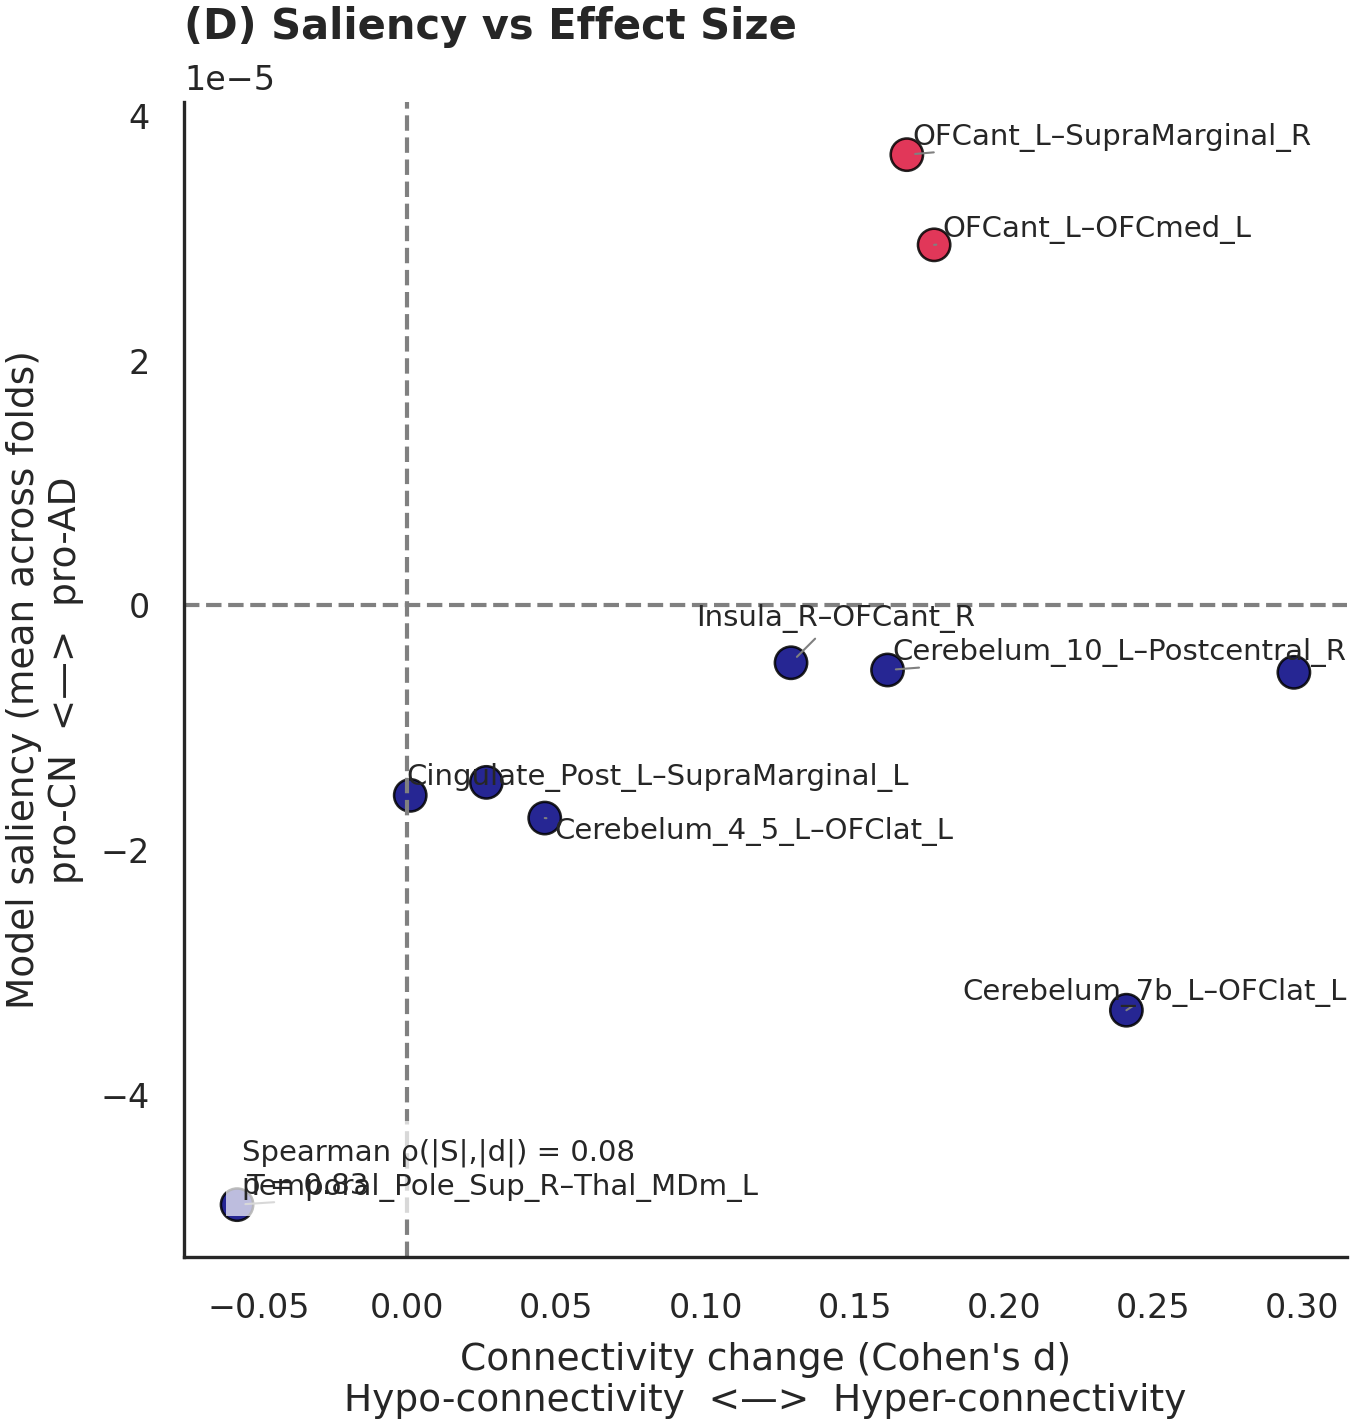

✅ Fig (D) guardada en: Figures_Nature/fig4D_saliency_vs_effect.pdf


In [8]:
# =================== CELDA FIG (D) — Saliency vs Effect Size ===================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

try:
    from adjustText import adjust_text
    _HAS_ADJUST_TEXT = True
except ImportError:
    _HAS_ADJUST_TEXT = False
    def adjust_text(*args, **kwargs):
        return

assert 'df_full' in globals()
assert 'df_cohen_all' in globals()
assert 'consensus_set' in globals()

FIG_D_NAME = "fig4D_saliency_vs_effect"

# 1) Saliencia media por conexión (sobre folds)
df_mean_sal = (
    df_full
    .groupby("connection_id")["Saliency_Signed"]
    .mean()
    .rename("saliency_mean")
)

# 2) Tomamos mean_cohen_d
cohen_df = df_cohen_all[["mean_cohen_d"]].rename(columns={"mean_cohen_d": "cohen_d"})

# 3) Merge y filtro al consensus_set
df_qc = (
    pd.concat([df_mean_sal, cohen_df], axis=1)
      .dropna()
      .loc[df_mean_sal.index.intersection(consensus_set.index)]
)

if df_qc.empty:
    raise RuntimeError("df_qc quedó vacío: revisa que consensus_set y df_cohen_all compartan índices.")

# 4) Correlación Spearman en magnitud
rho, pval = spearmanr(df_qc["saliency_mean"].abs(), df_qc["cohen_d"].abs())

# 5) Scatter plot
fig_D, ax_D = plt.subplots(figsize=(5, 5))

sns.scatterplot(
    data=df_qc,
    x="cohen_d",
    y="saliency_mean",
    s=60,
    edgecolor="black",
    alpha=0.85,
    ax=ax_D,
    hue=(df_qc["saliency_mean"] > 0),
    palette={True: "crimson", False: "navy"},
    legend=False,
)

ax_D.axhline(0, c="grey", ls="--", lw=1)
ax_D.axvline(0, c="grey", ls="--", lw=1)

ax_D.set_title("(D) Saliency vs Effect Size", loc="left", weight="bold")
ax_D.set_xlabel("Connectivity change (Cohen's d)\nHypo-connectivity  <—>  Hyper-connectivity")
ax_D.set_ylabel("Model saliency (mean across folds)\npro-CN  <—>  pro-AD")

ax_D.text(
    0.05, 0.05,
    f"Spearman ρ(|S|,|d|) = {rho:.2f}\np = {pval:.2g}",
    transform=ax_D.transAxes,
    fontsize=7,
    va="bottom", ha="left",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
)

# 6) Etiquetar las conexiones más extremas (saliencia)
extreme = pd.concat([
    df_qc.nlargest(4, "saliency_mean"),
    df_qc.nsmallest(4, "saliency_mean")
]).drop_duplicates()

texts = []
for conn, row in extreme.iterrows():
    label = f"{conn[0]}–{conn[1]}"
    t = ax_D.text(row["cohen_d"], row["saliency_mean"], label, fontsize=7)
    texts.append(t)

if _HAS_ADJUST_TEXT:
    adjust_text(texts, ax=ax_D, arrowprops=dict(arrowstyle="-", color="gray", lw=0.5))

savefig_nature(fig_D, FIG_DIR / FIG_D_NAME)
fig_D.savefig(FIG_DIR / f"{FIG_D_NAME}.svg", format="svg", bbox_inches="tight")
plt.show()

print(f"✅ Fig (D) guardada en: {FIG_DIR / (FIG_D_NAME + '.pdf')}")


Resumen lateralidad (TopK):


TopK  n_folds  mean_p_RR  std_p_RR    t_stat   p_value
0    50        5   0.507385  0.254580  0.064862  0.951396
1   100        5   0.500106  0.156729  0.001508  0.998869
2   200        5   0.507849  0.121840  0.144040  0.892435

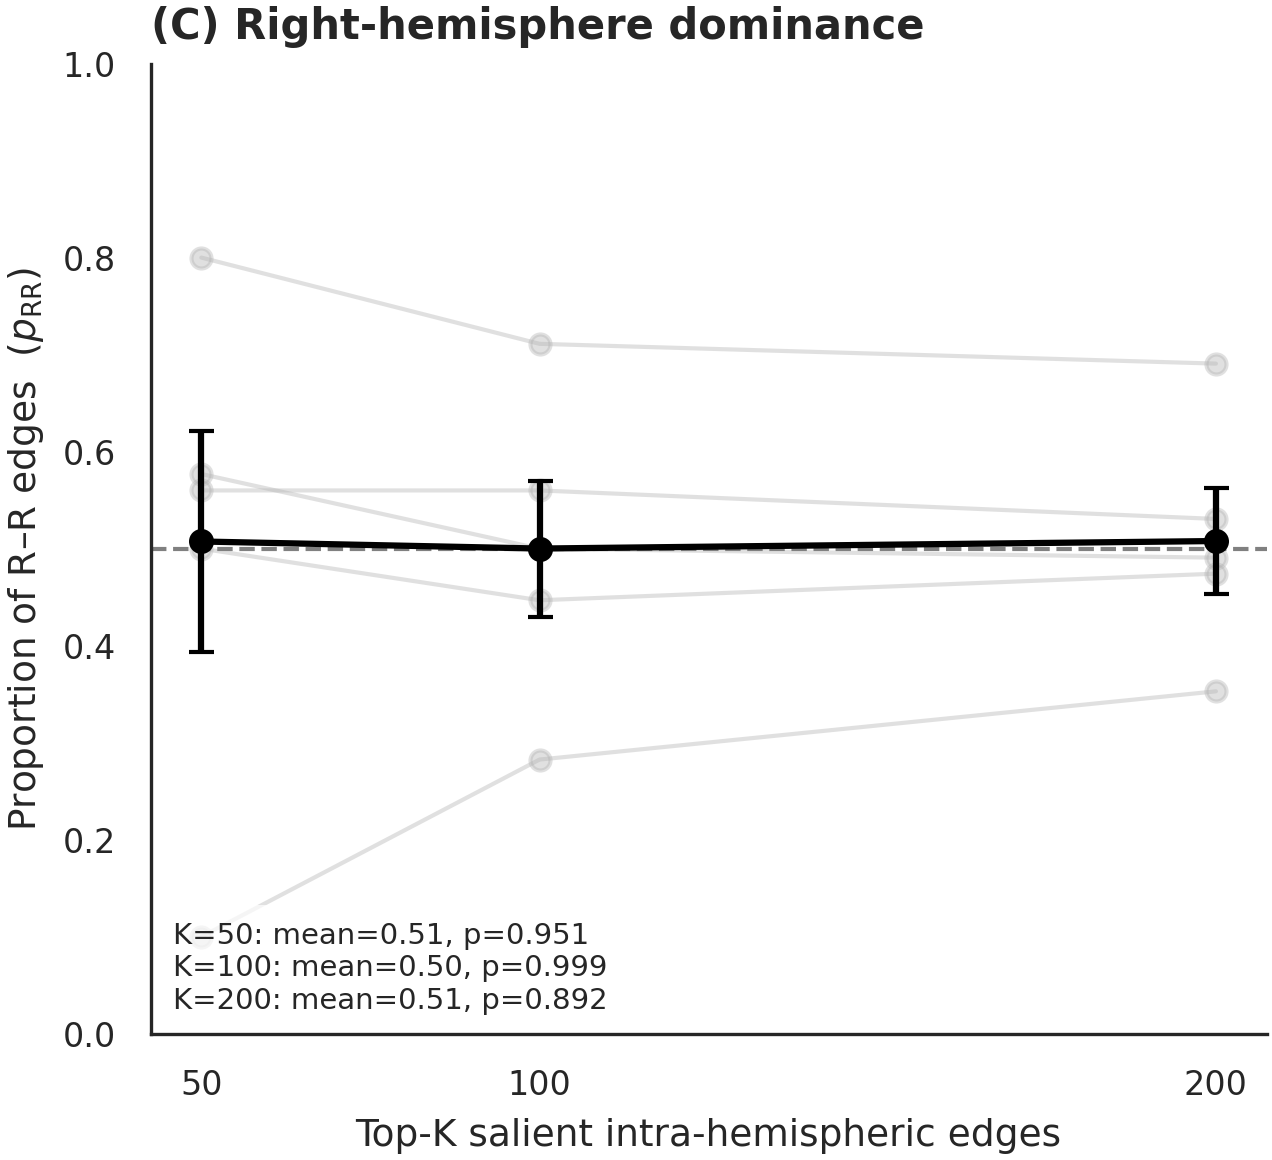

✅ Fig (C) guardada en: Figures_Nature/fig4C_right_hemi_dominance.pdf


In [9]:
# =================== CELDA FIG (C) — Right-hemisphere dominance ===================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp

assert 'df_lat_plot' in globals()

FIG_C_NAME = "fig4C_right_hemi_dominance"

# --- Resumen estadístico por TopK ---
stats_rows = []
for K in sorted(df_lat_plot["TopK"].unique()):
    vals = df_lat_plot.loc[df_lat_plot["TopK"] == K, "p_RR"].dropna().to_numpy()
    if len(vals) == 0:
        continue
    t, p = ttest_1samp(vals, 0.5)  # H0: p_RR = 0.5
    stats_rows.append({
        "TopK": K,
        "n_folds": len(vals),
        "mean_p_RR": np.mean(vals),
        "std_p_RR": np.std(vals, ddof=1),
        "t_stat": t,
        "p_value": p,
    })

df_lat_stats = pd.DataFrame(stats_rows)
print("Resumen lateralidad (TopK):")
display(df_lat_stats)

# --- Figura: p_RR por fold y TopK ---
set_nature_style()

fig_C, ax_C = plt.subplots(figsize=(4.8, 4.2))

# 1) Puntos por fold (ligeras líneas grises)
for f, g in df_lat_plot.groupby("fold", observed=True):
    ax_C.plot(
        g["TopK"], g["p_RR"],
        marker="o", linestyle="-",
        alpha=0.4, linewidth=1.0,
        color="0.7",
    )

# 2) Media ± SEM por TopK
Ks = df_lat_stats["TopK"].to_numpy()
means = df_lat_stats["mean_p_RR"].to_numpy()
sems  = df_lat_stats["std_p_RR"].to_numpy() / np.sqrt(df_lat_stats["n_folds"].to_numpy())

ax_C.errorbar(
    Ks, means, yerr=sems,
    fmt="o-", linewidth=1.5, markersize=5,
    color="black", capsize=3, label="Mean ± SEM"
)

# 3) Línea de referencia 0.5 (simetría)
ax_C.axhline(0.5, color="grey", linestyle="--", linewidth=1)

ax_C.set_title("(C) Right-hemisphere dominance", loc="left", weight="bold")
ax_C.set_xlabel("Top-K salient intra-hemispheric edges")
ax_C.set_ylabel(r"Proportion of R–R edges  ($p_{\mathrm{RR}}$)")

ax_C.set_xticks(sorted(df_lat_plot["TopK"].unique()))
ax_C.set_ylim(0.0, 1.0)

# Pequeña anotación con p-values
txt_lines = []
for _, row in df_lat_stats.iterrows():
    txt_lines.append(f"K={int(row['TopK'])}: mean={row['mean_p_RR']:.2f}, p={row['p_value']:.3f}")
ax_C.text(
    0.02, 0.02,
    "\n".join(txt_lines),
    transform=ax_C.transAxes,
    ha="left", va="bottom",
    fontsize=7,
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
)

savefig_nature(fig_C, FIG_DIR / FIG_C_NAME)
plt.show()

print(f"✅ Fig (C) guardada en: {FIG_DIR / (FIG_C_NAME + '.pdf')}")


/tmp/ipykernel_324135/898113654.py:91: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  mask_img = new_img_like(aal_img, mask)


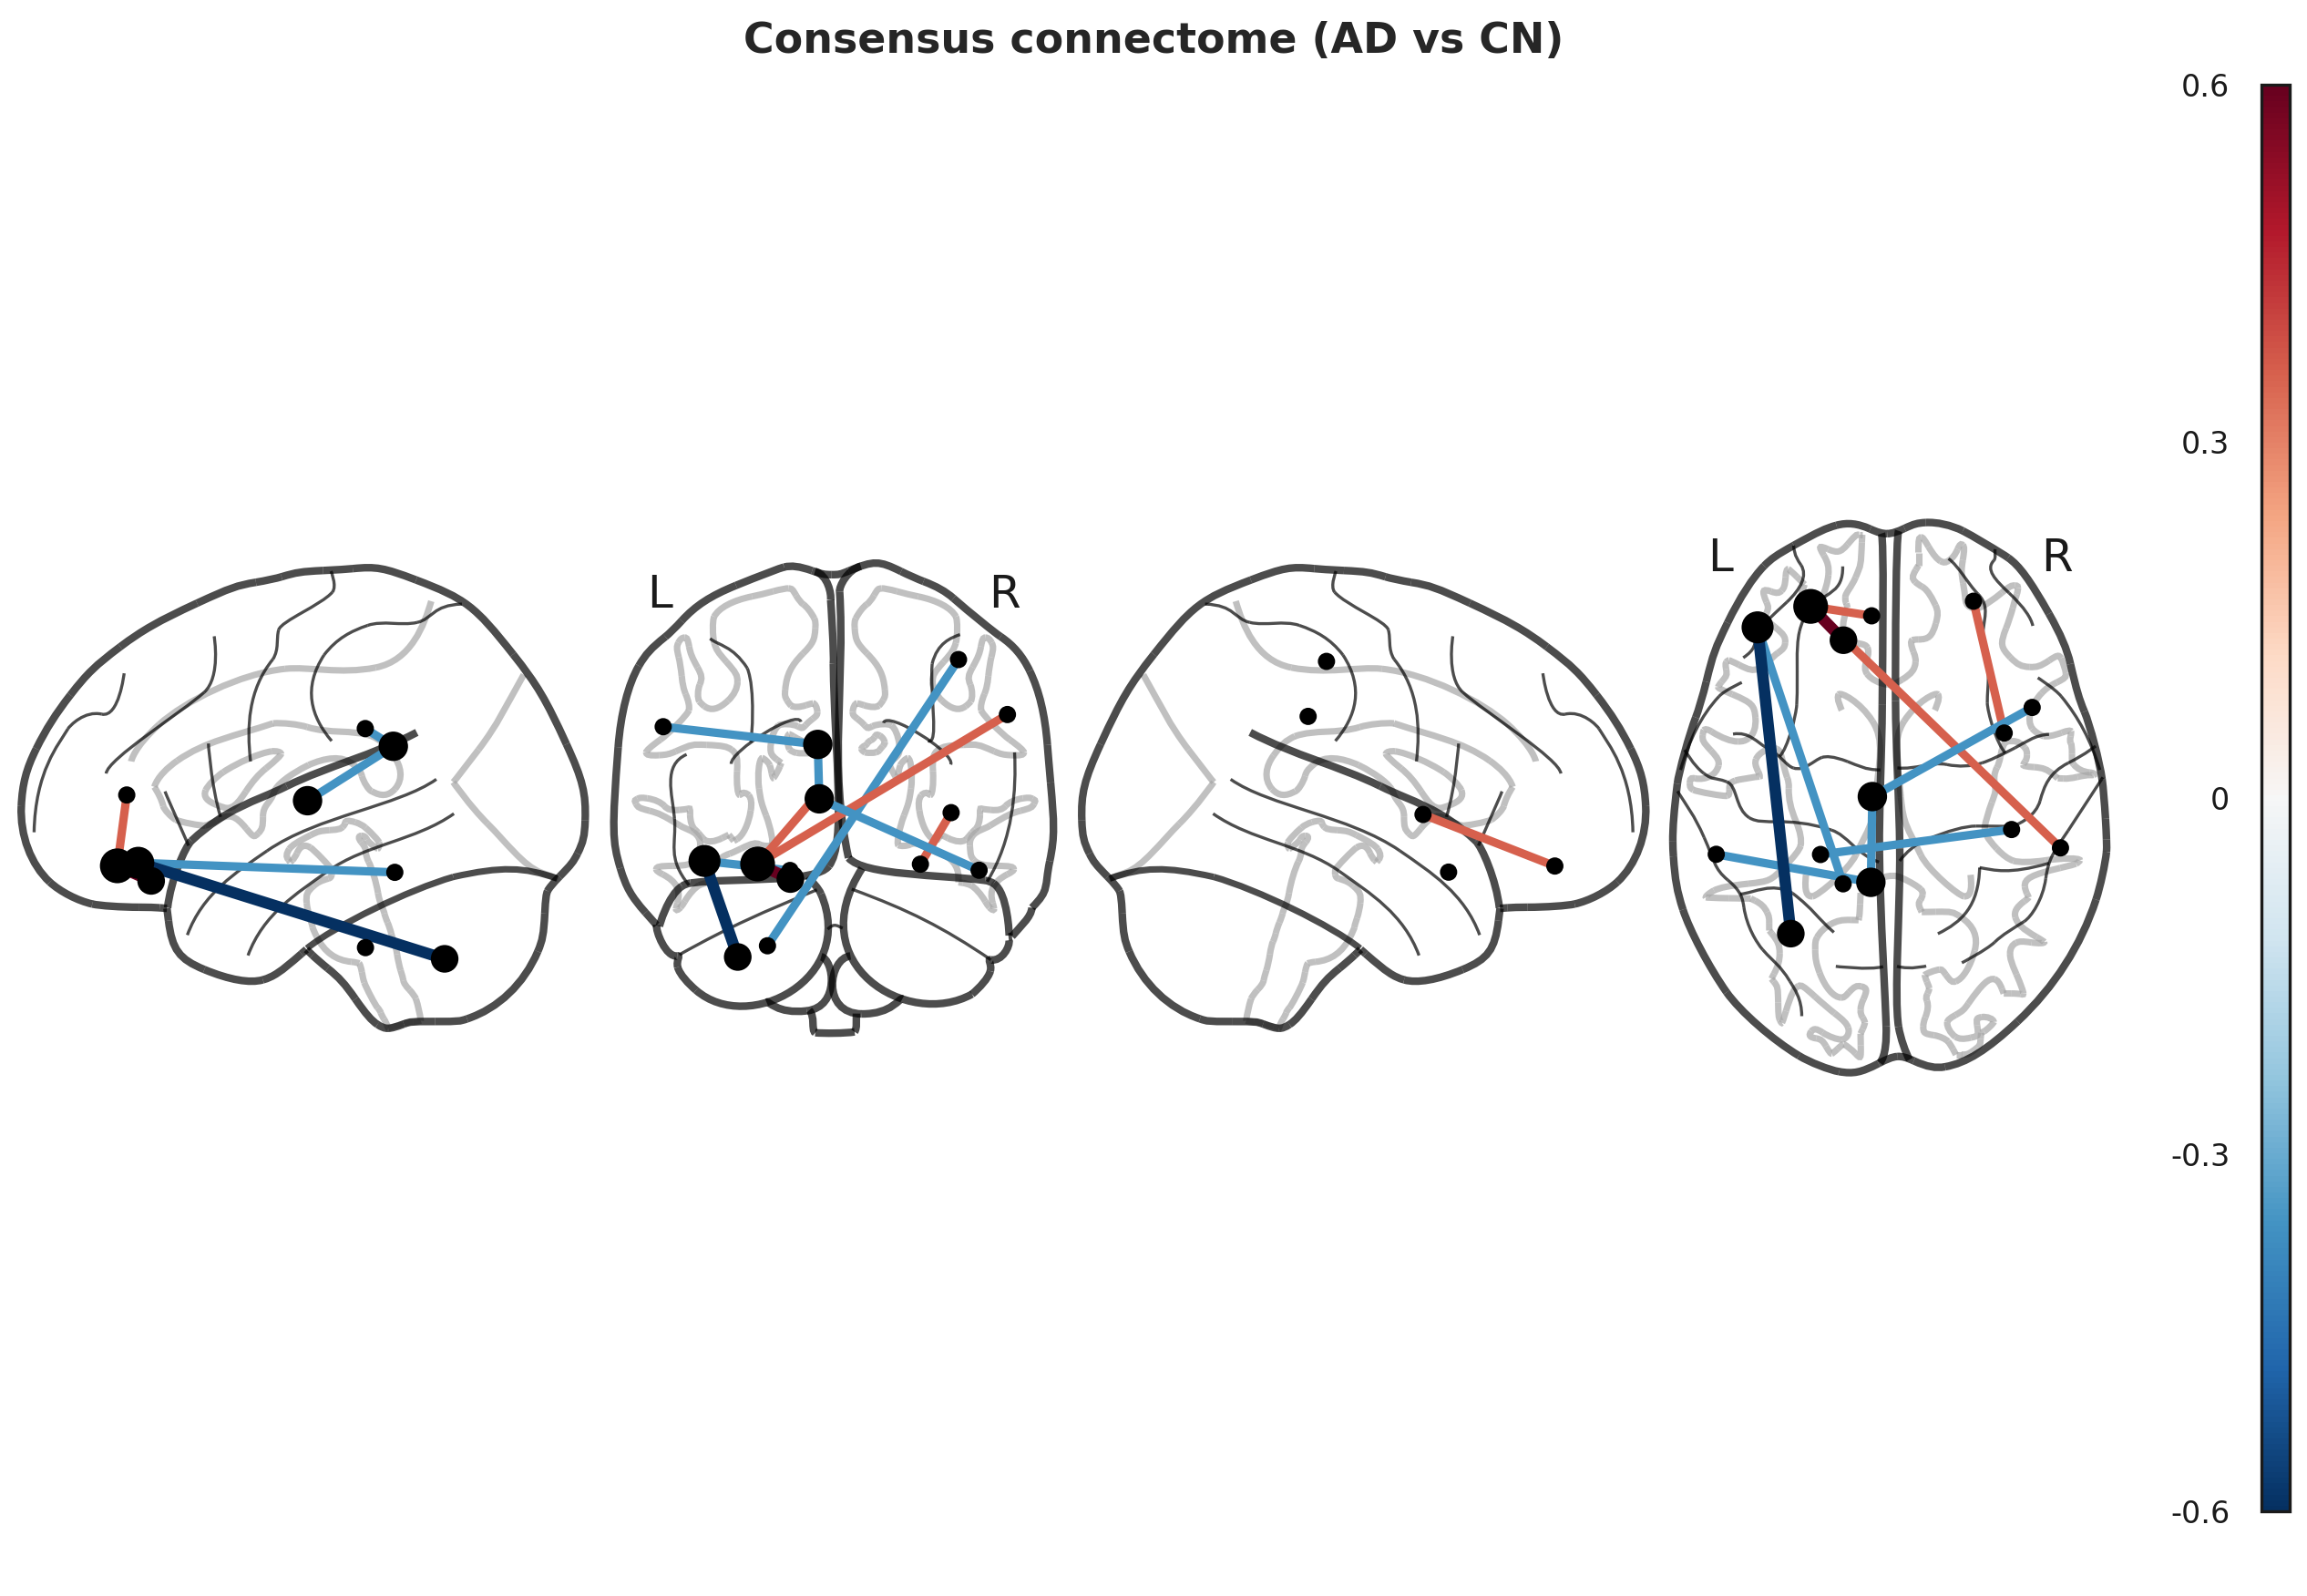


Resumen — consenso firmado:
  • Aristas pro-AD (rojo): 4
  • Aristas pro-CN (azul): 6
  • Escala |w| máx.: 0.600
✅ Guardado connectome en: Figures_Nature/fig4E_glass_brain_consensus.[pdf|png|svg]
✅ Guardado node-strength en: Figures_Nature/fig4F_nodestrength_signed.[pdf|png|svg]


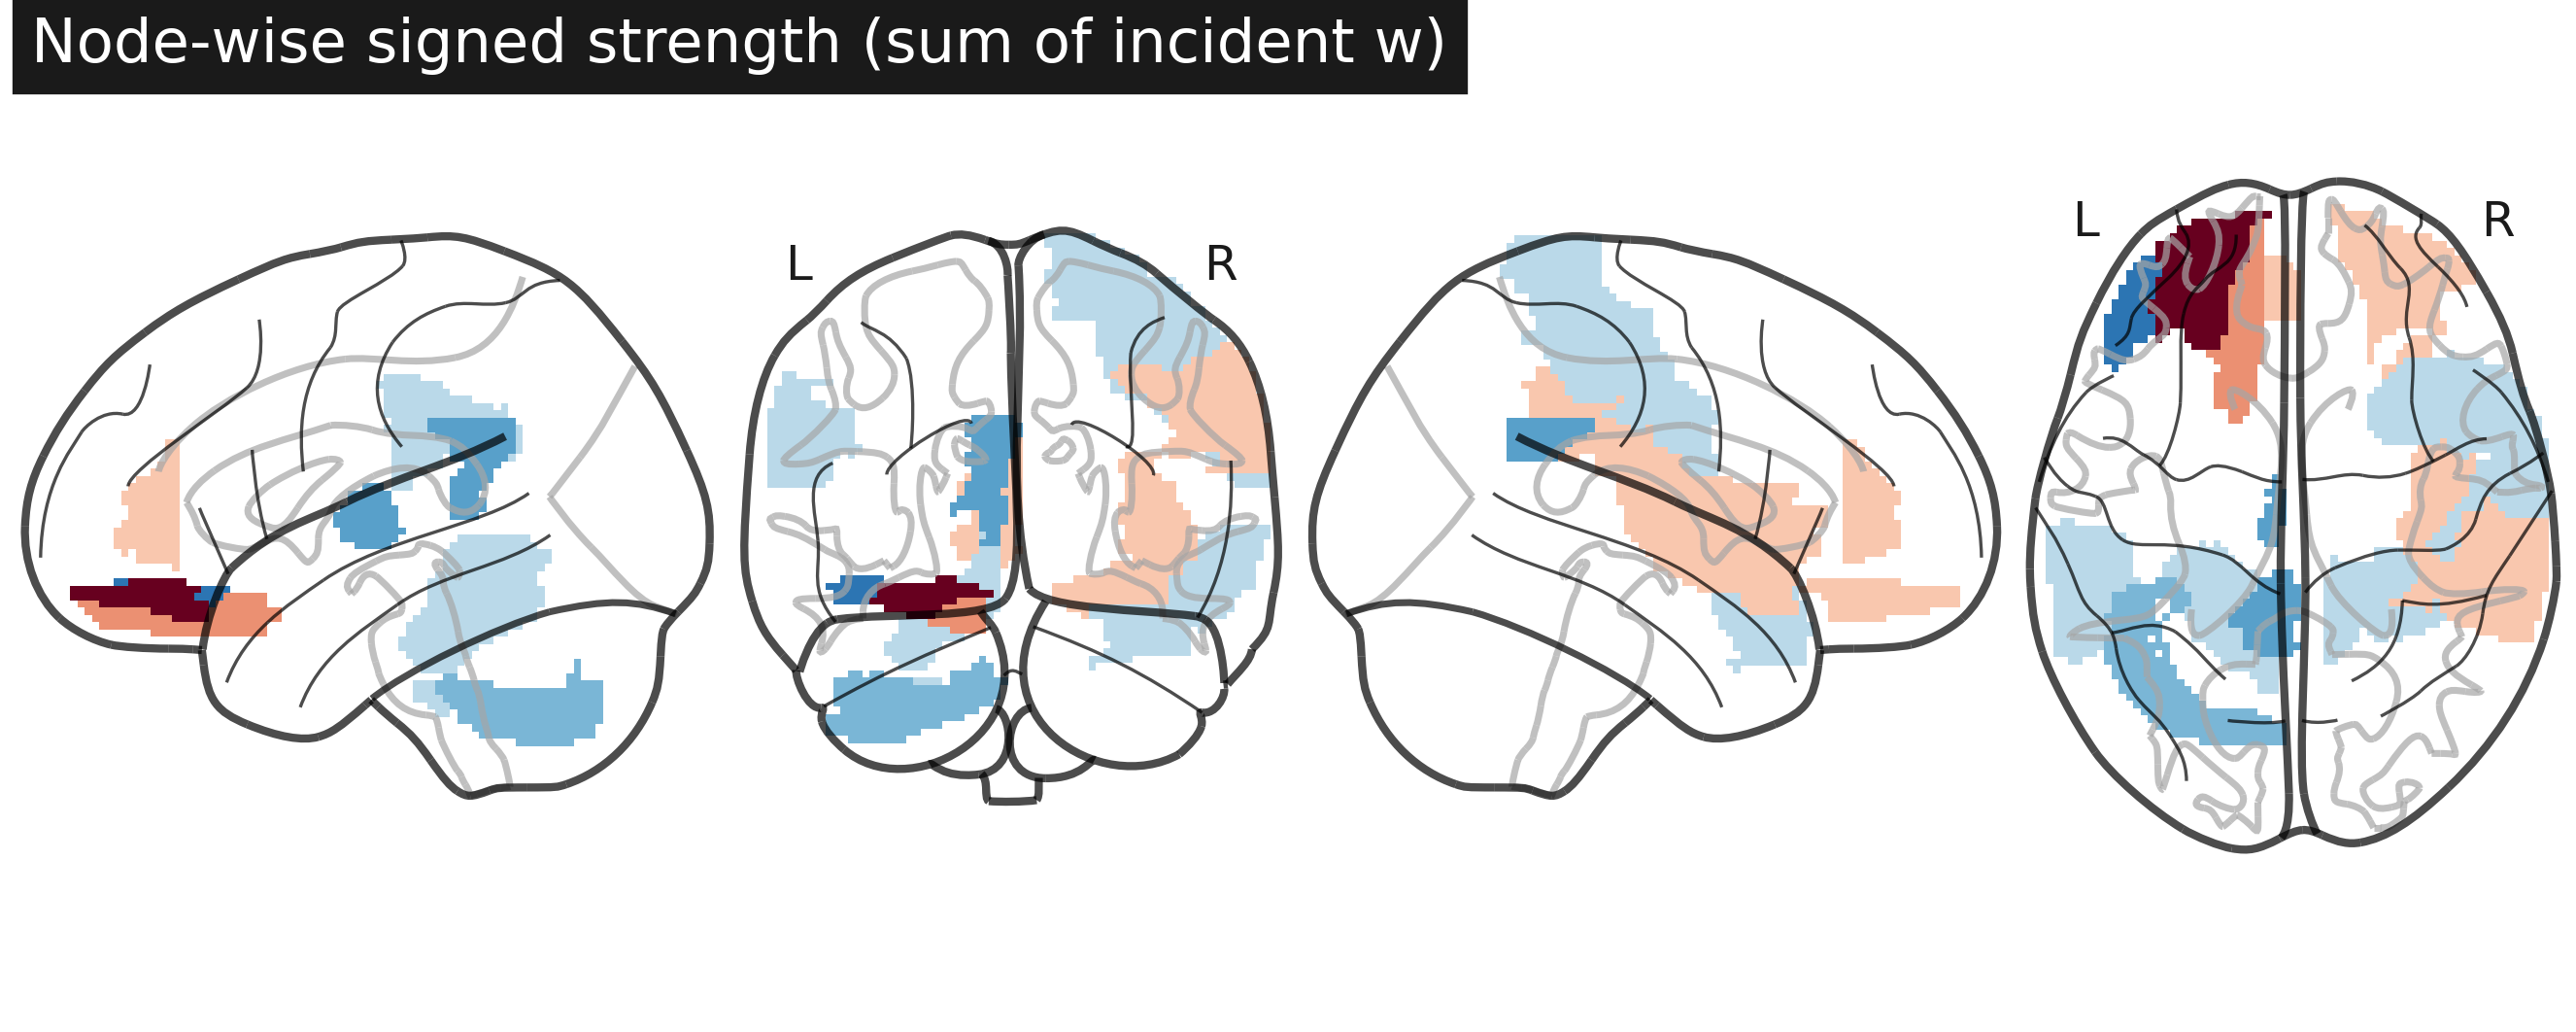

In [10]:
# =================== CELDA — Glass brain de la firma de consenso (AAL3-based) ===================
import re
import warnings
from pathlib import Path

import numpy as np
import nibabel as nib
from scipy.io import loadmat
import matplotlib.pyplot as plt
from nilearn.image import new_img_like
from nilearn.plotting import plot_connectome, plot_glass_brain, find_xyz_cut_coords

assert 'consensus_set' in globals()
assert 'FIG_DIR' in globals()
assert 'savefig_nature' in globals()

FIG_G_NAME = "fig4E_glass_brain_consensus"

# 🔧 AJUSTAR ESTA RUTA SEGÚN DONDE TENGAS EL AAL3
AAL3_DIR = Path("/home/diego/proyectos/betavae-xai-ad/data")

# ------------------------ Helpers AAL3 ------------------------
def _canon(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9]", "", str(s)).upper()

def _abbr_tokens(name: str) -> str:
    toks = re.split(r"[^A-Za-z0-9]+", name)
    short = []
    for t in toks:
        if not t:
            continue
        if t.isdigit():
            short.append(t)
        elif len(t) <= 3:
            short.append(t.upper())
        else:
            short.append(t[:3].upper())
    return "".join(short)

def _load_aal3_paths(aal_dir: Path):
    cand_nii = [aal_dir/"AAL3v1.nii.gz", aal_dir/"AAL3v1.nii", aal_dir/"ROI_MNI_V7.nii"]
    cand_mat = [aal_dir/"ROI_MNI_V7_List.mat", aal_dir/"ROI_MNI_V7_List.mat"]
    cand_txt = [aal_dir/"AAL3v1.nii.txt", aal_dir/"ROI_MNI_V7_vol.txt"]
    AAL_NII = next((p for p in cand_nii if p.exists()), None)
    AAL_MAT = next((p for p in cand_mat if p.exists()), None)
    AAL_TXT = next((p for p in cand_txt if p.exists()), None)
    assert AAL_NII is not None, "❌ No encuentro el NIfTI del atlas AAL3."
    assert AAL_MAT is not None, "❌ No encuentro ROI_MNI_V7_List.mat."
    return AAL_NII, AAL_MAT, AAL_TXT

def _build_name_index(AAL_MAT, AAL_TXT):
    mat = loadmat(str(AAL_MAT))
    ROI_arr = mat["ROI"]
    name2id, canon2id = {}, {}
    for col in range(ROI_arr.shape[1]):
        item = ROI_arr[0, col]
        idx  = int(item["ID"][0][0])
        nomc = str(item["Nom_C"][0]).strip()
        noml = str(item["Nom_L"][0]).strip()
        for nm in {nomc, noml}:
            name2id[nm] = idx
            canon2id[_canon(nm)] = idx
            canon2id[_abbr_tokens(nm)] = idx
    if AAL_TXT and AAL_TXT.exists():
        for line in AAL_TXT.read_text(encoding="utf-8", errors="ignore").splitlines():
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = re.split(r"\s+", line, maxsplit=1)
            if len(parts) == 2 and parts[0].isdigit():
                idx = int(parts[0])
                lbl = parts[1].strip()
                name2id[lbl] = idx
                canon2id[_canon(lbl)] = idx
                canon2id[_abbr_tokens(lbl)] = idx
    return name2id, canon2id

def resolve_roi_to_id(roi_name: str, name2id, canon2id):
    if roi_name in name2id:
        return name2id[roi_name], roi_name
    c = _canon(roi_name)
    if c in canon2id:
        return canon2id[c], roi_name
    a = _abbr_tokens(roi_name)
    if a in canon2id:
        return canon2id[a], roi_name
    return None, None

def roi_center_mni(label_id: int, aal_img, atlas_data):
    mask = (atlas_data == int(label_id)).astype(int)
    mask_img = new_img_like(aal_img, mask)
    return find_xyz_cut_coords(mask_img)

def build_adj_from_consensus(roi_order, df_cons, weight_col="w_signed"):
    pos = {r: i for i, r in enumerate(roi_order)}
    n = len(roi_order)
    A = np.zeros((n, n), dtype=float)
    for (a, b), row in df_cons.iterrows():
        if a in pos and b in pos:
            w = float(row[weight_col])
            i, j = pos[a], pos[b]
            A[i, j] = A[j, i] = w
    return A

# ------------------------ (1) Preparar consenso firmado ------------------------
# Nos aseguramos que haya w_signed:
if "w_signed" not in consensus_set.columns:
    raise RuntimeError("consensus_set existe pero no tiene columna 'w_signed'.")

cons = consensus_set.copy()
if cons.empty:
    raise RuntimeError("consensus_set está vacío. Ajustá CONS_PI/CONS_TAU o TOP_K_STABILITY.")

# ROIs únicas del consenso
roi_names = sorted({roi for (a, b) in cons.index for roi in (a, b)})

# ------------------------ (2) Mapeo AAL3 → coords MNI ------------------------
AAL_NII, AAL_MAT, AAL_TXT = _load_aal3_paths(AAL3_DIR)
aal_img = nib.load(str(AAL_NII))
atlas_data = aal_img.get_fdata().astype(int)
name2id, canon2id = _build_name_index(AAL_MAT, AAL_TXT)

resolved_ids, unresolved = {}, []
for nm in roi_names:
    idx, _ = resolve_roi_to_id(nm, name2id, canon2id)
    if idx is not None:
        resolved_ids[nm] = idx
    else:
        unresolved.append(nm)

if unresolved:
    warnings.warn(f"ROIs sin resolver (no se dibujan en el connectome): {unresolved}")

roi_order = [r for r in roi_names if r in resolved_ids]
coords    = [roi_center_mni(resolved_ids[r], aal_img, atlas_data) for r in roi_order]

if not roi_order:
    raise RuntimeError("Ningún ROI del consenso obtuvo coordenadas MNI válidas (revisar mapeo AAL3).")

# ------------------------ (3) Matriz de adyacencia y tamaños nodales ------------------------
A = build_adj_from_consensus(roi_order, cons, "w_signed")
if not np.any(A):
    raise RuntimeError("La matriz de adyacencia quedó vacía (w_signed=0 en todas). Revisá los cortes o w_signed.")

node_strength_signed = pd.Series(A.sum(axis=1), index=roi_order)
node_strength_abs    = pd.Series(np.abs(A).sum(axis=1), index=roi_order)

S = node_strength_abs.to_numpy()
S = (S - S.min()) / (S.max() - S.min() + 1e-12)   # [0,1]
NODE_MIN, NODE_MAX = 14, 70
node_sizes = np.clip(NODE_MIN + (NODE_MAX - NODE_MIN) * np.sqrt(S), NODE_MIN, NODE_MAX)

# ------------------------ (4) Figura connectome ==========================
set_nature_style()
vmax = float(np.abs(A).max())
fig = plt.figure(figsize=(8.4, 5.8))

disp = plot_connectome(
    adjacency_matrix=A,
    node_coords=coords,
    node_color="black",
    node_size=node_sizes,
    edge_cmap="RdBu_r",
    edge_vmin=-vmax, edge_vmax=vmax,
    colorbar=True,
    display_mode="lyrz",
    figure=fig,
)

plt.suptitle("Consensus connectome (AD vs CN)", y=0.99, fontsize=11, weight="bold")

# Guardar en PDF/PNG/SVG
out_base = FIG_DIR / FIG_G_NAME
savefig_nature(fig, out_base)
fig.savefig(str(out_base) + ".svg", format="svg", bbox_inches="tight")
plt.show()

# ------------------------ (5) Mapa nodal en glass brain (opcional) ------------------------
stat_vol = np.zeros_like(atlas_data, dtype=float)
for roi_name in roi_order:
    idx = resolved_ids[roi_name]
    stat_vol[atlas_data == int(idx)] = node_strength_signed[roi_name]

stat_img = new_img_like(aal_img, stat_vol)
vmax_nodes = float(np.nanmax(np.abs(stat_vol))) if np.isfinite(np.nanmax(np.abs(stat_vol))) else None

disp2 = plot_glass_brain(
    stat_img, plot_abs=False, threshold=0,
    display_mode="lyrz",
    cmap="RdBu_r", black_bg=False,
    symmetric_cbar=True,
    title="Node-wise signed strength (sum of incident w)",
    vmax=vmax_nodes,
)

base2 = FIG_DIR / "fig4F_nodestrength_signed"
disp2.savefig(str(base2) + ".pdf")
disp2.savefig(str(base2) + ".png", dpi=300)
disp2.savefig(str(base2) + ".svg")

# ------------------------ (6) Mini resumen ------------------------
n_pos = int((A >  0).sum() // 2)
n_neg = int((A <  0).sum() // 2)
print("\nResumen — consenso firmado:")
print(f"  • Aristas pro-AD (rojo): {n_pos}")
print(f"  • Aristas pro-CN (azul): {n_neg}")
print(f"  • Escala |w| máx.: {vmax:.3f}")
print("✅ Guardado connectome en:", str(out_base) + ".[pdf|png|svg]")
print("✅ Guardado node-strength en:", str(base2) + ".[pdf|png|svg]")


In [12]:
# =================== CELDA — Export de tablas para paper/suplemento ===================
assert 'consensus_set' in globals()
assert 'df_stability' in globals()
assert 'df_cohen_all' in globals()
assert 'df_lat_stats' in globals()
assert 'df_full' in globals()
assert 'roi2net' in globals()

# --- Meta por conexión (ROIs, redes) ---
meta_conn = (
    df_full[["connection_id", "src_AAL3_Name", "dst_AAL3_Name"]]
    .drop_duplicates("connection_id")
    .set_index("connection_id")
)

meta_conn["src_net"] = meta_conn["src_AAL3_Name"].map(roi2net)
meta_conn["dst_net"] = meta_conn["dst_AAL3_Name"].map(roi2net)

# --- Consensus edges + estabilidad + efecto de grupo ---
consensus_export = (
    consensus_set
    .reset_index()                         # connection_id
    .merge(meta_conn.reset_index(), on="connection_id", how="left")
    .merge(df_cohen_all[["mean_cohen_d"]].reset_index(),
           on="connection_id", how="left")
    .rename(columns={
        "src_AAL3_Name": "ROI_src",
        "dst_AAL3_Name": "ROI_dst",
        "src_net": "Network_src",
        "dst_net": "Network_dst",
        "mean_cohen_d": "Cohen_d_AD_minus_CN"
    })
)

cols_order = [
    "ROI_src", "ROI_dst",
    "Network_src", "Network_dst",
    "pi", "tau", "signedness",
    "stability_mag", "w_signed",
    "Cohen_d_AD_minus_CN",
    "connection_id",
]

consensus_export = consensus_export[cols_order]

out_cons = TBL_DIR / "Table_ConsensusEdges_signature.csv"
consensus_export.to_csv(out_cons, index=False)
print("✅ Exportada tabla de aristas de consenso a:", out_cons)

# --- Lateralidad ---
out_lat = TBL_DIR / "Table_Lateralization_stats.csv"
df_lat_stats.to_csv(out_lat, index=False)
print("✅ Exportada tabla de lateralidad a:", out_lat)

# --- Spearman S vs |d| (lo imprimimos y lo guardamos simple) ---
rho, pval = spearmanr(
    df_qc["saliency_mean"].abs(),
    df_qc["cohen_d"].abs()
)

out_spear = TBL_DIR / "Summary_Spearman_saliency_vs_effect.txt"
with open(out_spear, "w") as f:
    f.write(f"Spearman rho(|S|,|d|) = {rho:.4f}\n")
    f.write(f"p-value = {pval:.4g}\n")
    f.write(f"N_edges = {len(df_qc)}\n")

print("✅ Resumen Spearman guardado en:", out_spear)
print(f"   Spearman rho(|S|,|d|) = {rho:.3f}, p = {pval:.3g}, N = {len(df_qc)}")


✅ Exportada tabla de aristas de consenso a: Tables_Nature/Table_ConsensusEdges_signature.csv
✅ Exportada tabla de lateralidad a: Tables_Nature/Table_Lateralization_stats.csv
✅ Resumen Spearman guardado en: Tables_Nature/Summary_Spearman_saliency_vs_effect.txt
   Spearman rho(|S|,|d|) = 0.079, p = 0.829, N = 10


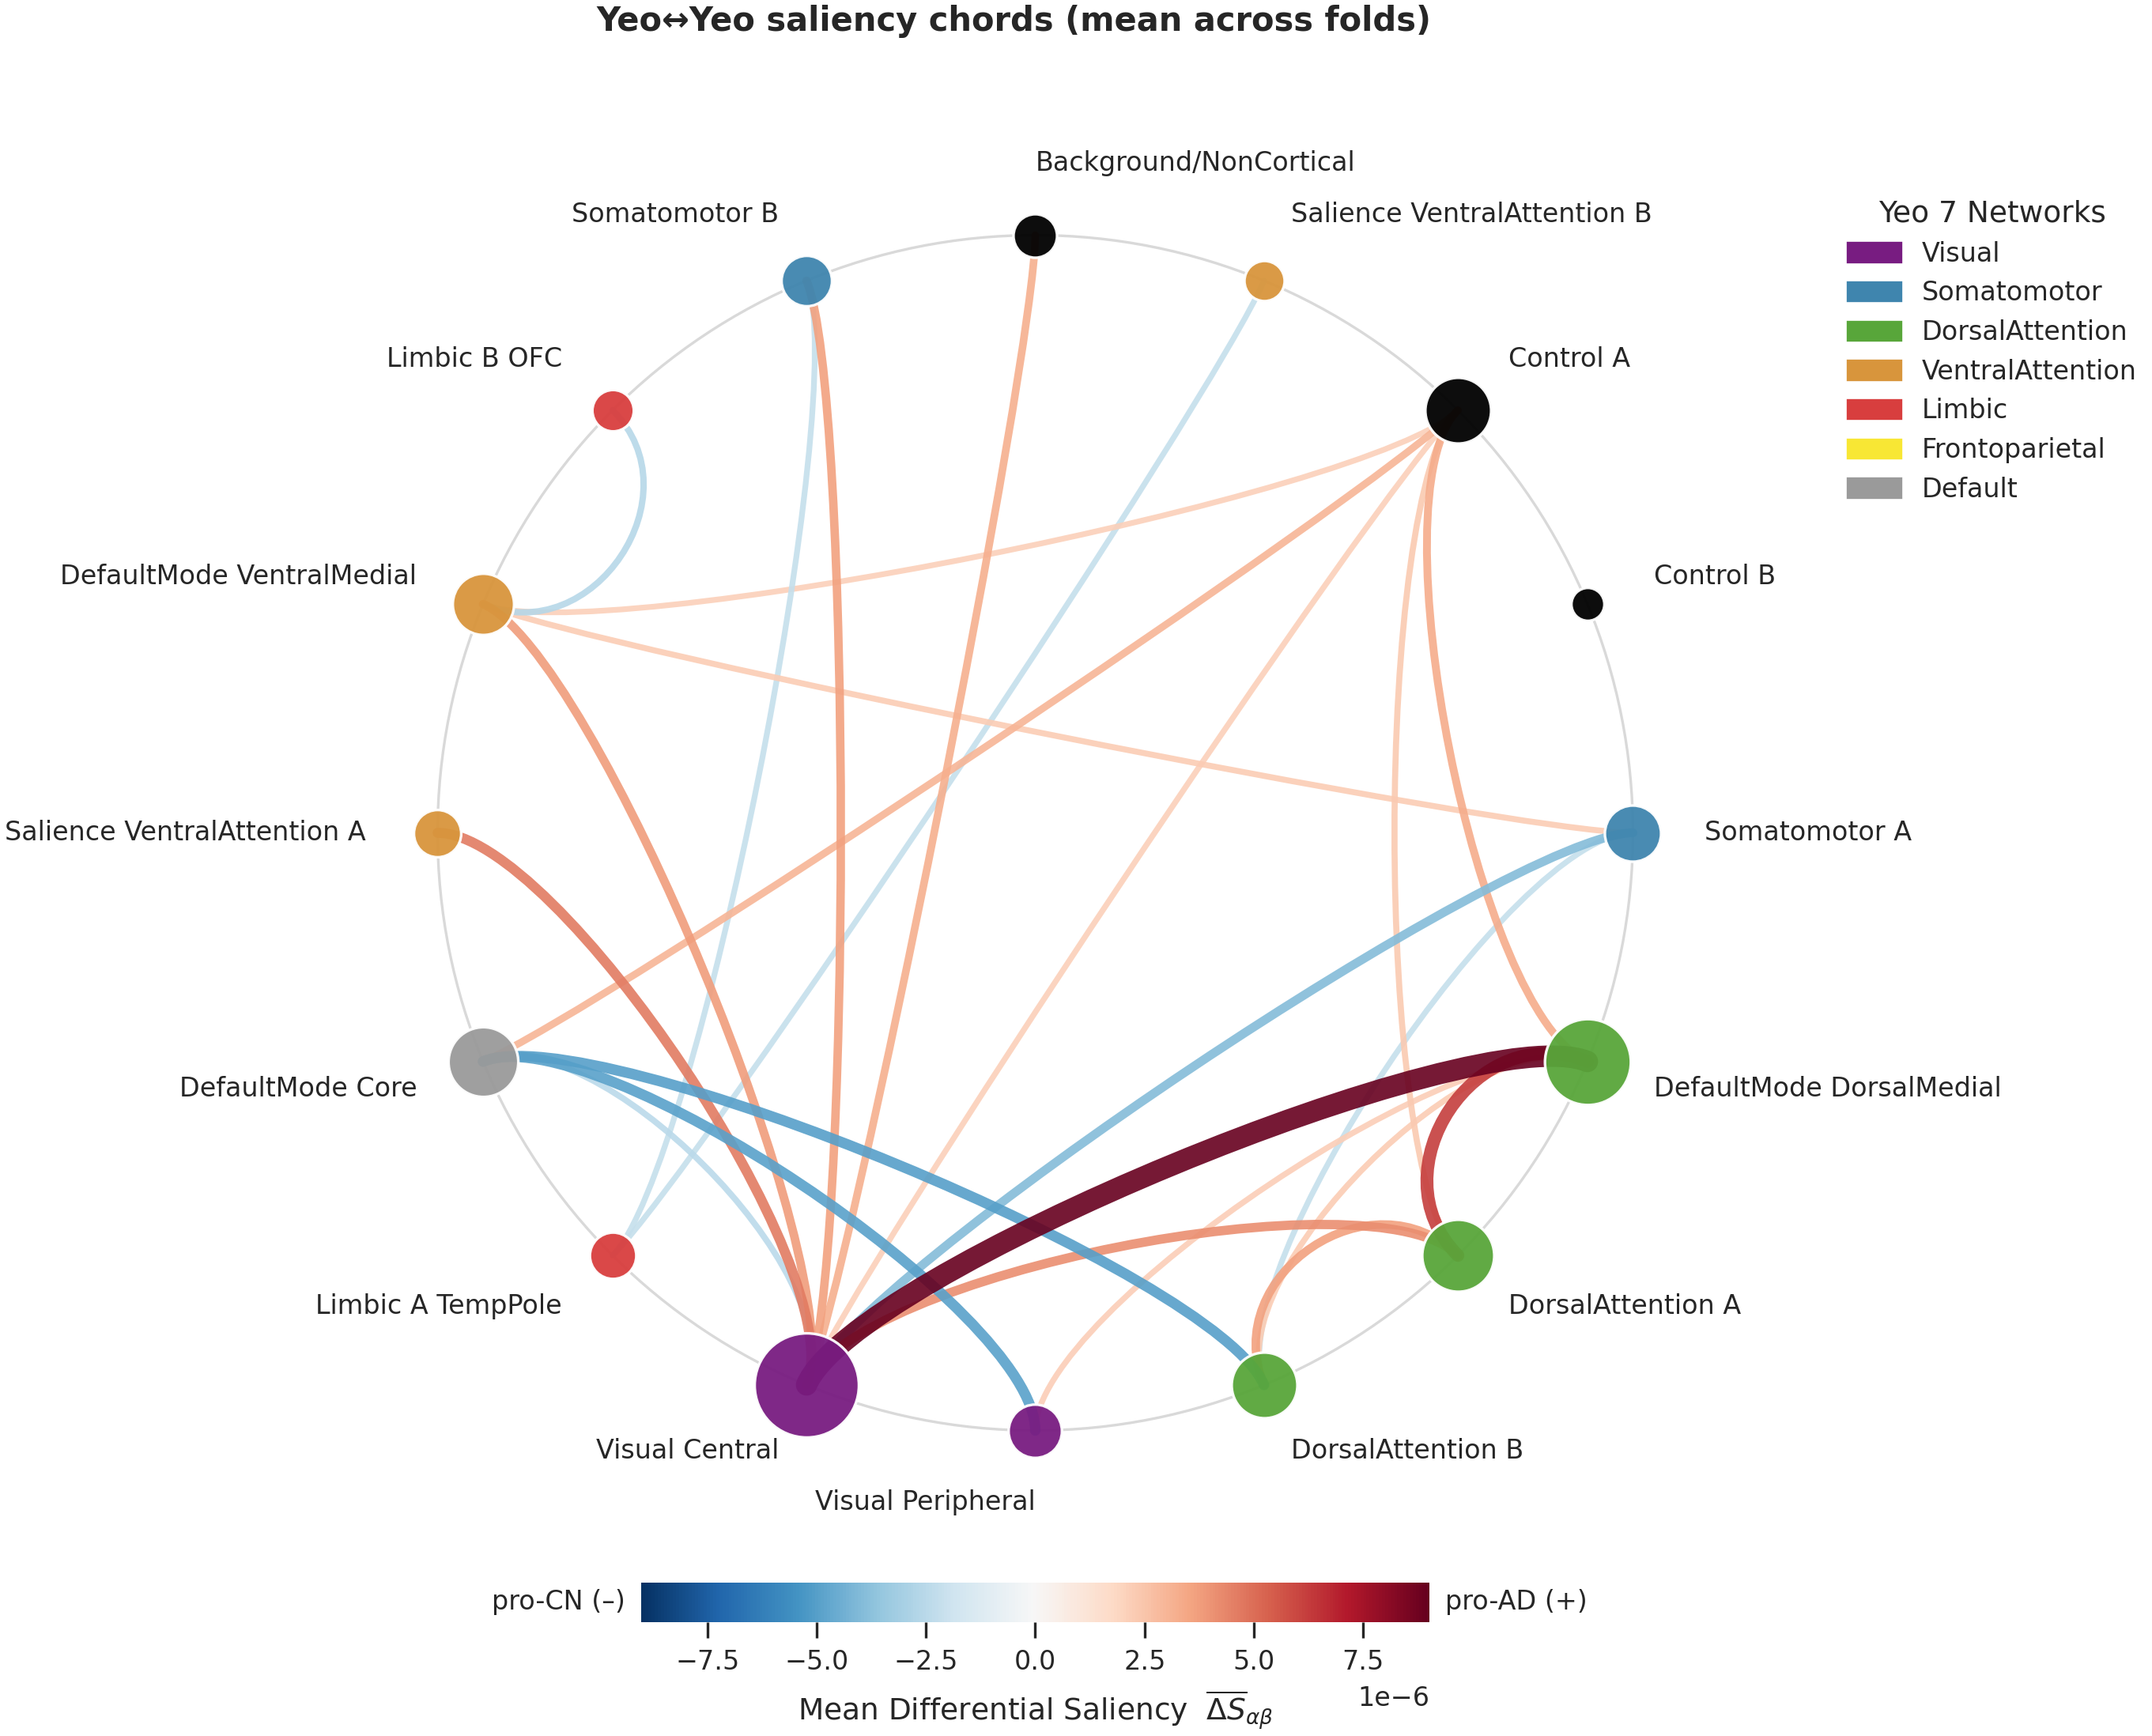

✅ Chord Yeo↔Yeo guardado en: Figures_Nature/fig_YeoChord_AAL3manual.[pdf|png|svg]
Orden de redes (AAL3 manual): ['Somatomotor_A', 'Control_B', 'Control_A', 'Salience_VentralAttention_B', 'Background/NonCortical', 'Somatomotor_B', 'Limbic_B_OFC', 'DefaultMode_VentralMedial', 'Salience_VentralAttention_A', 'DefaultMode_Core', 'Limbic_A_TempPole', 'Visual_Central', 'Visual_Peripheral', 'DorsalAttention_B', 'DorsalAttention_A', 'DefaultMode_DorsalMedial']


In [18]:
# ======================= CELDA — Chord Yeo↔Yeo (AAL3 manual order) =======================
import pathlib
from datetime import datetime as _dt
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import colormaps as mpl_cmaps
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch, Circle
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ======================== PARÁMETROS DE LA FIGURA ========================
TOP_K_PAIRS = 24
AGGREGATE_ACROSS_FOLDS = True
FOLD_TO_SHOW = 1
CMAP = 'RdBu_r'
FIGSIZE = (7.2, 7.2)
R_BASE, R_LABEL = 1.00, 1.12
CURVE_INSET = 0.80
ORDER_MODE = 'yeo'       # sólo se usa como *fallback* si falla el CSV manual
NODE_COLOR_MODE = 'yeo'
MIN_ABS_WEIGHT = 0.0

# 🔧 AJUSTAR ESTA RUTA EN TU ENTORNO LOCAL SI HACE FALTA
AAL3_MANUAL_ORDER_CSV = pathlib.Path("/home/diego/proyectos/betavae-xai-ad/data/aal3_131_manual_network_order.csv")

# Nombre de salida estable (sin timestamp para reproducibilidad)
CHORD_FIG_NAME = "fig_YeoChord_AAL3manual"
outname = FIG_DIR / CHORD_FIG_NAME

# ======================== ORDEN YEO7 Y COLORES ========================
YEO7_ORDER = ['Visual', 'Somatomotor', 'DorsalAttention', 'VentralAttention', 
              'Limbic', 'Frontoparietal', 'Default']

YEO_COLOR_MAP = {
    'visual': '#781C81',
    'somato': '#3F85AE',
    'dorsal': '#58A63A',
    'ventral': '#D8953C',
    'limbic': '#D83E3E',
    'fronto': '#F8E734',
    'default': '#9A9A9A'
}

def guess_yeo_color(name: str, default='black'):
    n = str(name).lower()
    for key, col in YEO_COLOR_MAP.items():
        if key in n:
            return col
    return default

def _bezier_chord(ax, p1, p2, lw, color, alpha=0.9, inset=0.80):
    ctrl1, ctrl2 = p1 * inset, p2 * inset
    path = MplPath(
        [p1, ctrl1, ctrl2, p2],
        [MplPath.MOVETO, MplPath.CURVE4, MplPath.CURVE4, MplPath.CURVE4]
    )
    ax.add_patch(
        PathPatch(
            path,
            facecolor='none',
            edgecolor=color,
            lw=lw,
            alpha=alpha,
            capstyle='round'
        )
    )

def _order_from_manual_aal3(networks_raw, csv_path: pathlib.Path):
    """
    Devuelve una lista de redes ordenadas según aal3_131_manual_network_order.csv:
    se toma el mínimo Index_131 de cada Yeo17_Network_manual y se ordena por ahí.
    Se restringe al subconjunto de `networks_raw` (las redes efectivamente presentes
    en mat).
    """
    if not csv_path.exists():
        print(f"⚠️ No se encontró el CSV manual: {csv_path}. Se usará orden heurístico.")
        return None

    aal = pd.read_csv(csv_path)
    if "Yeo17_Network_manual" not in aal.columns or "Index_131" not in aal.columns:
        print("⚠️ El CSV manual no tiene columnas 'Yeo17_Network_manual' / 'Index_131'. "
              "Se usará orden heurístico.")
        return None

    aal["Yeo17_Network_manual"] = (
        aal["Yeo17_Network_manual"]
        .astype(str)
        .str.strip()
    )

    # Orden global de redes según el primer ROI que las contiene
    net_order_df = (
        aal[["Yeo17_Network_manual", "Index_131"]]
        .dropna(subset=["Yeo17_Network_manual"])
        .groupby("Yeo17_Network_manual", as_index=False)["Index_131"]
        .min()
        .sort_values("Index_131")
    )
    full_order = net_order_df["Yeo17_Network_manual"].tolist()

    # Intersección con las redes efectivamente presentes en la matriz
    networks_raw = [str(n).strip() for n in networks_raw]
    full_order = [str(n).strip() for n in full_order]

    # Mapa "limpio" → original, por si hubiera espacios raros
    raw_map = {str(n).strip(): n for n in networks_raw}

    ordered = [raw_map[n] for n in full_order if n in raw_map]
    remaining = [n for n in networks_raw if n not in ordered]

    if remaining:
        print("ℹ️ Redes presentes en df_full pero no en el CSV manual (añadidas al final):")
        print("   ", remaining)

    if not ordered:
        # Nada coincidió: devolvemos None para forzar el fallback
        return None

    return ordered + remaining

# ======================== PREPARACIÓN DE DATOS ========================
# Elegimos columnas de red (Refined / Yeo17)
ns = 'src_Refined_Network' if 'src_Refined_Network' in df_full.columns else 'src_Yeo17_Network'
nd = 'dst_Refined_Network' if 'dst_Refined_Network' in df_full.columns else 'dst_Yeo17_Network'

cols = [ns, nd, 'Saliency_Signed']
if 'fold' in df_full.columns:
    cols.append('fold')

_df = df_full[cols].dropna(subset=[ns, nd, 'Saliency_Signed']).copy()

if not AGGREGATE_ACROSS_FOLDS and 'fold' in _df.columns:
    _df = _df[_df['fold'] == FOLD_TO_SHOW].copy()

title_suffix = 'mean across folds' if AGGREGATE_ACROSS_FOLDS else f'fold {FOLD_TO_SHOW}'

# Matriz red×red de saliencia media (simetrizada)
mat = _df.groupby([ns, nd])['Saliency_Signed'].mean().unstack(fill_value=0.0)
mat = (mat + mat.T) / 2.0

networks_raw = sorted(mat.index.union(mat.columns))
mat = mat.reindex(index=networks_raw, columns=networks_raw).fillna(0.0)

# Lista de edges (pares de redes) con su peso medio
edges = []
for i, a in enumerate(networks_raw):
    for j, b in enumerate(networks_raw):
        if j <= i:
            continue
        w = float(mat.loc[a, b])
        if abs(w) >= MIN_ABS_WEIGHT:
            edges.append((a, b, w, abs(w)))

if not edges:
    raise ValueError("No hay pares de redes para graficar (edges vacíos).")

k = int(min(TOP_K_PAIRS, len(edges)))
edges_top = sorted(edges, key=lambda t: t[3], reverse=True)[:k]

# Fuerza nodal (suma de |w|) para tamaño de nodos
node_strength = pd.Series(0.0, index=networks_raw)
for a, b, w, aw in edges_top:
    node_strength[a] += aw
    node_strength[b] += aw

# ======================== ORDEN FINAL DE NODOS ========================
# Primero intentamos el orden manual basado en AAL3
net_order = _order_from_manual_aal3(networks_raw, AAL3_MANUAL_ORDER_CSV)

# Si falla, usamos el orden heurístico por Yeo7 como antes
if net_order is None:
    if ORDER_MODE == 'yeo':
        def _get_order_key(name):
            n_lower = str(name).lower()
            for idx, canon in enumerate(YEO7_ORDER):
                if canon.lower() in n_lower:
                    return (idx, str(name))
            return (len(YEO7_ORDER), str(name))
        net_order = sorted(networks_raw, key=_get_order_key)
    else:
        net_order = sorted(networks_raw)

# ======================== FIGURA CHORD ========================
set_nature_style()

theta = np.linspace(0, 2 * np.pi, len(net_order), endpoint=False)
pos = {net: np.array([R_BASE * np.cos(t), R_BASE * np.sin(t)])
       for net, t in zip(net_order, theta)}

vmax = np.percentile([aw for *_, aw in edges_top], 98) if edges_top else 1.0
if not np.isfinite(vmax) or vmax <= 1e-6:
    vmax = 1.0

norm = Normalize(vmin=-vmax, vmax=vmax)
cmap = mpl_cmaps.get_cmap(CMAP)

max_abs = max((aw for *_, aw in edges_top), default=1.0)
def width_from_abs(aw):
    return float(np.clip(0.6 + 6.0 * (aw / (max_abs + 1e-12)), 0.6, 6.5))

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_aspect('equal')
ax.axis('off')

# Círculo base
ax.add_patch(
    Circle((0, 0), R_BASE, facecolor='none',
           edgecolor='0.85', lw=0.8, zorder=0)
)

# Arcos (chords)
for a, b, w, aw in sorted(edges_top, key=lambda t: t[3]):
    _bezier_chord(
        ax,
        pos[a],
        pos[b],
        lw=width_from_abs(aw),
        color=cmap(norm(w)),
        inset=CURVE_INSET
    )

# Nodos
for net in net_order:
    xy = pos[net]
    facecolor = guess_yeo_color(net) if NODE_COLOR_MODE == 'yeo' else 'black'
    max_ns = node_strength.max() if node_strength.max() > 0 else 1.0
    size = 100 + 900 * (node_strength.get(net, 0.0) / max_ns)

    ax.scatter(
        [xy[0]], [xy[1]],
        s=size,
        zorder=5,
        edgecolor='white',
        linewidth=0.8,
        color=facecolor,
        alpha=0.95
    )

    ang = np.arctan2(xy[1], xy[0])
    lx, ly = R_LABEL * np.cos(ang), R_LABEL * np.sin(ang)
    ax.text(
        lx, ly,
        str(net).replace('_', ' '),
        fontsize=8,
        ha='left' if lx >= 0 else 'right',
        va='center'
    )

# --- LEYENDA PARA LAS REDES YEO7 ---
key_map = {
    'Visual': 'visual',
    'Somatomotor': 'somato',
    'DorsalAttention': 'dorsal',
    'VentralAttention': 'ventral',
    'Limbic': 'limbic',
    'Frontoparietal': 'fronto',
    'Default': 'default'
}

legend_handles = [
    mpatches.Patch(color=YEO_COLOR_MAP[key_map[name]], label=name)
    for name in YEO7_ORDER
]

ax.legend(
    handles=legend_handles,
    title='Yeo 7 Networks',
    bbox_to_anchor=(1.1, 1.0),
    loc='upper left',
    fontsize=8,
    title_fontsize=9,
    frameon=False
)

# --- COLORBAR HORIZONTAL (FIX SVG) ---
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(np.linspace(-vmax, vmax, 256))  # ⟵ CLAVE: dar "datos" al mapeador

cax = inset_axes(ax, width="60%", height="3%", loc='lower center', borderpad=-5)
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label(r'Mean Differential Saliency  $\overline{\Delta S}_{\alpha\beta}$', fontsize=9)
cbar.solids.set_edgecolor("face")
cbar.outline.set_visible(False)

cbar.ax.text(
    1.02, 0.5, 'pro-AD (+)',
    transform=cbar.ax.transAxes,
    ha='left', va='center', fontsize=8
)
cbar.ax.text(
    -0.02, 0.5, 'pro-CN (–)',
    transform=cbar.ax.transAxes,
    ha='right', va='center', fontsize=8
)

plt.suptitle(f"Yeo↔Yeo saliency chords ({title_suffix})",
             y=0.98, fontsize=10, weight="bold")

# --- Guardado (PDF/PNG/SVG) ---
savefig_nature(fig, outname)
fig.savefig(outname.with_suffix(".svg"), format='svg', bbox_inches="tight")
plt.show()

print(f"✅ Chord Yeo↔Yeo guardado en: {outname}.[pdf|png|svg]")
print("Orden de redes (AAL3 manual):", net_order)


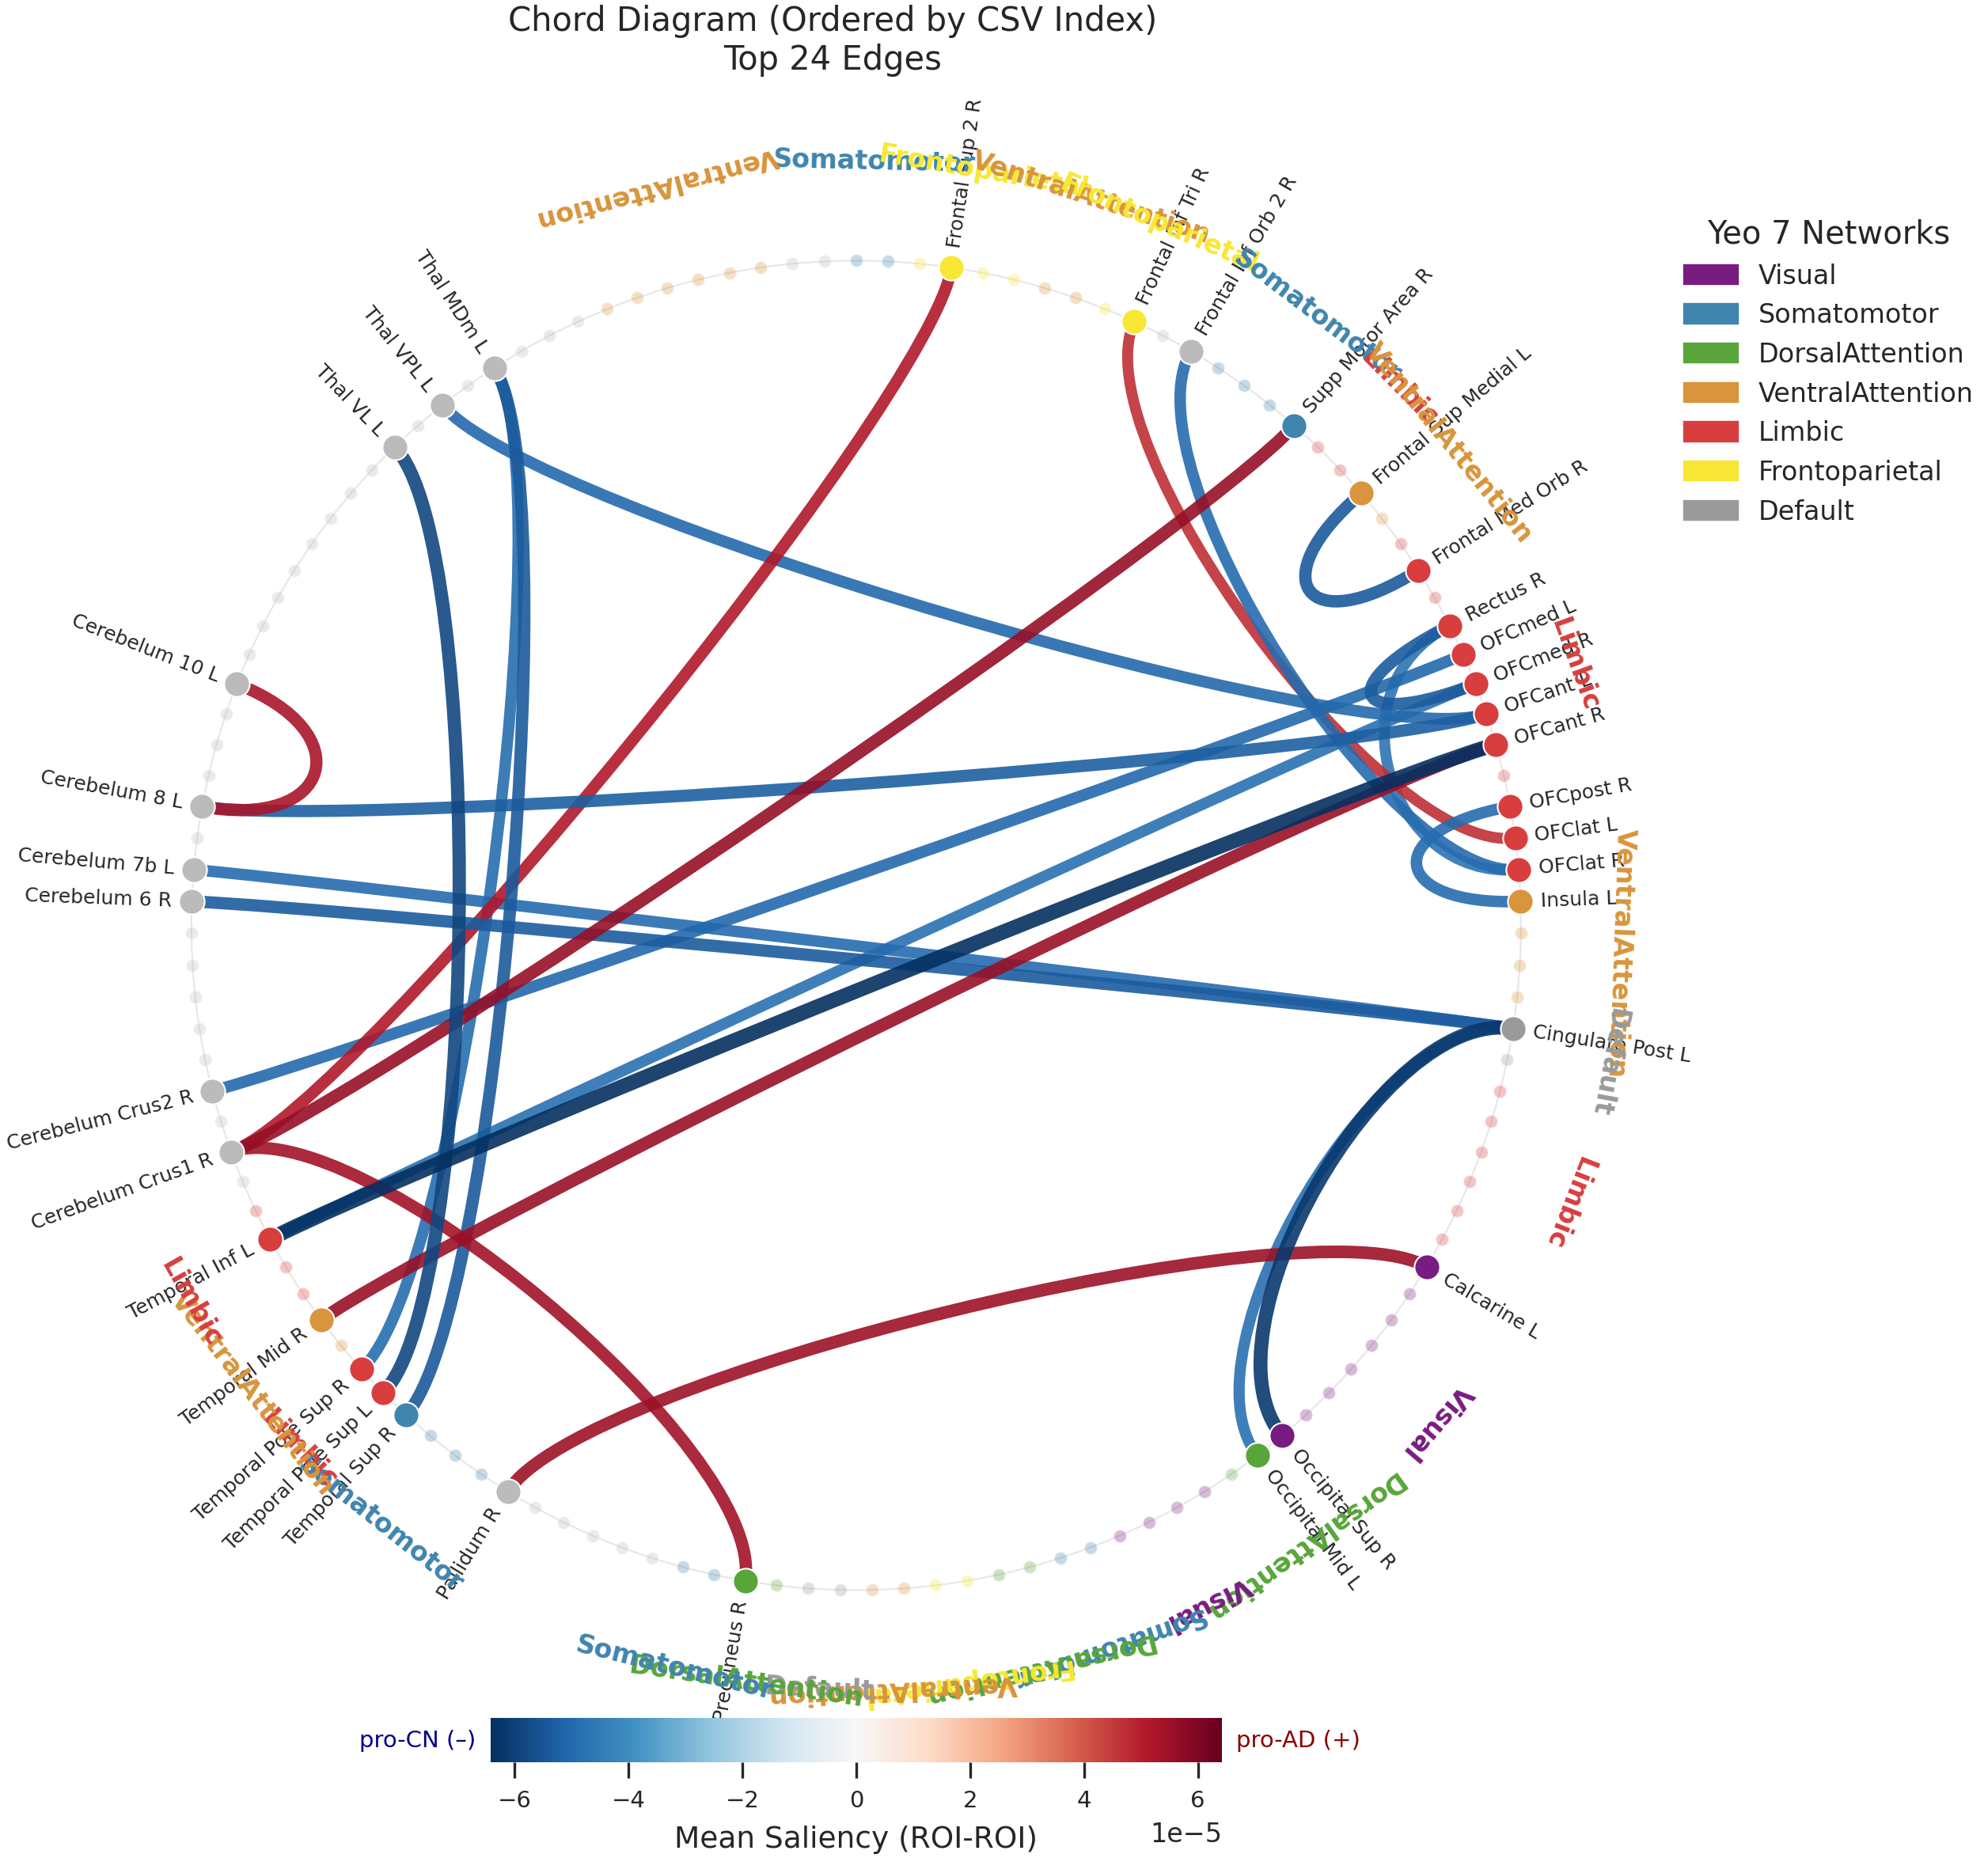

✅ Figura guardada en: Figures_Nature/fig_YeoChord_ROI_allfolds_20251125_1731.pdf / .svg


In [16]:
# ======================= CELDA — Chord ROI↔ROI (ORDENADO POR AAL3_131 CSV) =======================
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps as mpl_cmaps
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch, Circle
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from datetime import datetime as _dt

# ======================== PARÁMETROS ========================
TOP_K_PAIRS = 24            # Número de aristas (conexiones) a mostrar
AGGREGATE_ACROSS_FOLDS = True
FOLD_TO_SHOW = 1
CMAP_EDGES = 'RdBu_r'       # Mapa de color para las cuerdas (saliencia)
FIGSIZE = (8, 8)
R_BASE = 1.00               # Radio del círculo de nodos
R_TEXT_ROI = 1.03           # Radio para etiquetas de ROIs individuales
R_TEXT_NET = 1.15           # Radio para etiquetas de Redes (Arcos)
CURVE_INSET = 0.80          # Curvatura de las cuerdas (0 a 1)
MIN_ABS_WEIGHT = 0.0
CSV_ORDER_PATH = '/home/diego/proyectos/betavae-xai-ad/data/aal3_131_manual_network_order.csv'  # <--- TU ARCHIVO

outname = FIG_DIR / f"fig_YeoChord_ROI_{'allfolds' if AGGREGATE_ACROSS_FOLDS else f'fold{FOLD_TO_SHOW}'}_{_dt.now().strftime('%Y%m%d_%H%M')}"

# ======================== LÓGICA DE COLORES YEO ========================
YEO7_ORDER = ['Visual', 'Somatomotor', 'DorsalAttention', 'VentralAttention', 
              'Limbic', 'Frontoparietal', 'Default']

YEO_COLOR_MAP = {
    'visual': '#781C81', 'somato': '#3F85AE', 'dorsal': '#58A63A', 
    'ventral': '#D8953C', 'limbic': '#D83E3E', 'fronto': '#F8E734', 
    'default': '#9A9A9A', 'background': '#E0E0E0'
}

def get_broad_yeo_class(name: str):
    """Mapea el nombre detallado del CSV (ej: Visual_Peripheral) a las 7 clases generales."""
    n = str(name).lower()
    if 'visual' in n: return 'Visual'
    if 'somato' in n: return 'Somatomotor'
    if 'dorsal' in n: return 'DorsalAttention'
    if 'ventral' in n or 'salience' in n: return 'VentralAttention'
    if 'limbic' in n: return 'Limbic'
    if 'fronto' in n or 'control' in n: return 'Frontoparietal'
    if 'default' in n: return 'Default'
    return 'Other'

def get_yeo_color(broad_name: str):
    """Devuelve el hex color para la clase general."""
    k = broad_name.lower()
    if 'visual' in k: return YEO_COLOR_MAP['visual']
    if 'somato' in k: return YEO_COLOR_MAP['somato']
    if 'dorsal' in k: return YEO_COLOR_MAP['dorsal']
    if 'ventral' in k: return YEO_COLOR_MAP['ventral']
    if 'limbic' in k: return YEO_COLOR_MAP['limbic']
    if 'fronto' in k: return YEO_COLOR_MAP['fronto']
    if 'default' in k: return YEO_COLOR_MAP['default']
    return '#BBBBBB'

def _bezier_chord(ax, p1, p2, lw, color, alpha=0.9, inset=0.80):
    ctrl1, ctrl2 = p1 * inset, p2 * inset
    path = MplPath([p1, ctrl1, ctrl2, p2], 
                   [MplPath.MOVETO, MplPath.CURVE4, MplPath.CURVE4, MplPath.CURVE4])
    ax.add_patch(PathPatch(path, facecolor='none', edgecolor=color, lw=lw, alpha=alpha, capstyle='round'))

# ======================== 1. CARGA Y PREPARACIÓN DE DATOS (ROI LEVEL) ========================

# A) Cargar metadatos y orden del CSV
if not pathlib.Path(CSV_ORDER_PATH).exists():
    raise FileNotFoundError(f"No se encuentra {CSV_ORDER_PATH}")

df_meta = pd.read_csv(CSV_ORDER_PATH)
# Asegurar orden por Index_131
if 'Index_131' in df_meta.columns:
    df_meta = df_meta.sort_values('Index_131')

# Crear mapa: ROI_Name -> {Index, Network, BroadNet, Color}
# Usamos 'nom_l' como clave de enlace con df_full (asumiendo que df_full usa nombres largos AAL3)
roi_info = {}
for idx, row in df_meta.iterrows():
    rname = row['nom_l'].strip() # Limpieza básica
    broad = get_broad_yeo_class(row['Yeo17_Network_manual'])
    roi_info[rname] = {
        'order_idx': idx,  # Orden secuencial en el círculo (0 a 130)
        'network_raw': row['Yeo17_Network_manual'],
        'broad_net': broad,
        'color': get_yeo_color(broad)
    }

roi_order_list = list(roi_info.keys()) # Lista ordenada de ROIs para el círculo

# B) Preparar datos de conectividad (df_full) a nivel de ROI
_df = df_full.copy()
# Filtrar fold si es necesario
if not AGGREGATE_ACROSS_FOLDS and 'fold' in _df.columns:
    _df = _df[_df['fold'] == FOLD_TO_SHOW]

# Agregamos por par de ROIs (src_AAL3_Name, dst_AAL3_Name)
# Nota: Nos aseguramos de usar los nombres que coincidan con el CSV
grp_cols = ['src_AAL3_Name', 'dst_AAL3_Name']
mat_roi = _df.groupby(grp_cols)['Saliency_Signed'].mean()

# Extraer aristas válidas
edges = []
for (src, dst), w in mat_roi.items():
    src, dst = src.strip(), dst.strip()
    # Solo procesamos si ambos ROIs están en nuestro CSV de orden
    if src in roi_info and dst in roi_info:
        # Evitar duplicados (triángulo superior) o self-loops
        if src == dst: continue
        # Ordenamos tupla para unicidad no dirigida, aunque mat_roi puede tener ambos
        # (Aquí asumimos que queremos dibujar todo lo que venga fuerte)
        if abs(w) >= MIN_ABS_WEIGHT:
            edges.append((src, dst, w, abs(w)))

# Seleccionar Top-K por magnitud absoluta
if not edges: raise ValueError("No hay aristas para graficar tras filtrar por ROIs del CSV.")
k = int(min(TOP_K_PAIRS, len(edges)))
edges_top = sorted(edges, key=lambda t: t[3], reverse=True)[:k]

# ======================== 2. CONFIGURACIÓN DEL PLOT ========================

# Calcular ángulos para los 131 ROIs (sentido horario o antihorario)
# Empezamos en pi/2 (arriba) y vamos en sentido horario (negativo)
n_rois = len(roi_order_list)
thetas = np.linspace(np.pi/2, np.pi/2 - 2*np.pi, n_rois, endpoint=False)

roi_pos = {}
for i, name in enumerate(roi_order_list):
    t = thetas[i]
    roi_pos[name] = {'theta': t, 'xy': np.array([R_BASE*np.cos(t), R_BASE*np.sin(t)])}

# Normalización de colores para aristas
vmax = np.percentile([t[3] for t in edges_top], 98) if edges_top else 1.0
if vmax < 1e-6: vmax = 1.0
norm = Normalize(vmin=-vmax, vmax=vmax)
cmap = mpl_cmaps.get_cmap(CMAP_EDGES)

# Ancho de línea basado en magnitud
max_abs = max((t[3] for t in edges_top), default=1.0)
def width_from_abs(aw):
    return float(np.clip(0.5 + 4.0 * (aw / (max_abs + 1e-12)), 0.5, 5.0))

# ======================== 3. DIBUJAR FIGURA ========================
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_aspect('equal')
ax.axis('off')

# Círculo base tenue
ax.add_patch(Circle((0,0), R_BASE, facecolor='none', edgecolor='0.9', lw=0.5, zorder=0))

# A) Dibujar Cuerdas (Edges)
rois_with_edges = set()
for s, d, w, aw in sorted(edges_top, key=lambda t: t[3]): # Dibujar débiles primero (fondo) -> fuertes (frente)
    p1 = roi_pos[s]['xy']
    p2 = roi_pos[d]['xy']
    c_edge = cmap(norm(w))
    _bezier_chord(ax, p1, p2, lw=width_from_abs(aw), color=c_edge, inset=CURVE_INSET)
    rois_with_edges.add(s)
    rois_with_edges.add(d)

# B) Dibujar Nodos (ROIs)
for rname in roi_order_list:
    xy = roi_pos[rname]['xy']
    color = roi_info[rname]['color']
    
    # Tamaño: Grande si tiene arista top, pequeño si no
    size = 60 if rname in rois_with_edges else 15
    alpha = 1.0 if rname in rois_with_edges else 0.3
    zorder = 10 if rname in rois_with_edges else 5
    
    ax.scatter(xy[0], xy[1], s=size, color=color, edgecolor='white', lw=0.5, zorder=zorder, alpha=alpha)

    # Etiqueta del ROI (SOLO si está en el Top-K para no saturar)
    if rname in rois_with_edges:
        t = roi_pos[rname]['theta']
        # Rotación del texto para que apunte al centro
        rot = np.degrees(t)
        if 90 < rot < 270 or -270 < rot < -90:
            rot += 180
            ha = 'right'
        else:
            ha = 'left'
        
        # Ajuste de posición radial
        lx, ly = R_TEXT_ROI * np.cos(t), R_TEXT_ROI * np.sin(t)
        ax.text(lx, ly, rname.replace('_',' '), rotation=rot, ha=ha, va='center', fontsize=6, rotation_mode='anchor')

# C) Dibujar Etiquetas de REDES (Arcos exteriores)
# Identificamos bloques contiguos de la misma red en 'roi_order_list'
current_net = None
start_idx = 0

# Añadimos un dummy al final para cerrar el último bloque
processed_list = roi_order_list + [None] 

for i, rname in enumerate(processed_list):
    # Determinar red actual
    net = roi_info[rname]['broad_net'] if rname is not None else "END"
    
    if net != current_net:
        if current_net is not None and current_net != 'Other':
            # Dibujar arco para el bloque anterior (start_idx a i-1)
            # Ángulos promedio
            theta_start = thetas[start_idx]
            theta_end = thetas[i-1]
            
            # Manejo de cruce de 0/2pi si fuera necesario (aquí thetas es monótono decreciente, ok)
            theta_mid = (theta_start + theta_end) / 2
            
            # Coordenadas texto
            tx, ty = R_TEXT_NET * np.cos(theta_mid), R_TEXT_NET * np.sin(theta_mid)
            
            # Rotación del texto de la red
            rot_net = np.degrees(theta_mid) - 90 # Tangente al circulo (aprox)
            # Ajuste para lectura
            if theta_mid < -np.pi/2 or theta_mid > 3*np.pi/2: # Lado izquierdo
                 rot_net += 180

            # Color del texto
            c_net = get_yeo_color(current_net)
            
            # Dibujar Texto
            ax.text(tx, ty, current_net, color=c_net, fontsize=8, weight='bold',
                    ha='center', va='center', rotation=rot_net, rotation_mode='anchor')
            
            # (Opcional) Dibujar línea de arco
            # arc_path = ... (complejo en mpl puro, el texto suele bastar)

        current_net = net
        start_idx = i

# ======================== 4. LEYENDA Y COLORBAR ========================

# Leyenda de Redes (Arriba Izquierda o Derecha)
legend_handles = [mpatches.Patch(color=YEO_COLOR_MAP[key], label=name) 
                  for key, name in zip(['visual','somato','dorsal','ventral','limbic','fronto','default'], YEO7_ORDER)]

ax.legend(handles=legend_handles, title='Yeo 7 Networks', 
          loc='upper left', bbox_to_anchor=(1.05, 1.0), frameon=False, fontsize=8)

# Colorbar (Abajo)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(np.linspace(-vmax, vmax, 256))
cax = inset_axes(ax, width="50%", height="3%", loc='lower center', borderpad=-4)
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label(r'Mean Saliency (ROI-ROI)', fontsize=9)
cbar.outline.set_visible(False)
cbar.ax.tick_params(labelsize=7)
cbar.ax.text(1.02, 0.5, 'pro-AD (+)', transform=cbar.ax.transAxes, ha='left', va='center', fontsize=7, color='#8B0000')
cbar.ax.text(-0.02, 0.5, 'pro-CN (–)', transform=cbar.ax.transAxes, ha='right', va='center', fontsize=7, color='#00008B')

# ======================== 5. GUARDADO ========================
plt.suptitle(f"Chord Diagram (Ordered by CSV Index)\nTop {k} Edges", fontsize=10, y=0.98)
savefig_nature(fig, outname)
fig.savefig(outname.with_suffix(".svg"), format='svg', bbox_inches="tight")
plt.show()
print(f"✅ Figura guardada en: {outname}.pdf / .svg")